In [1]:
import os
import shutil
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import matplotlib.pyplot as plt  
from collections import deque
import flopy
from flopy.utils import Raster
import scipy
import rasterio
from flopy.utils.gridgen import Gridgen
from flopy.utils.gridintersect import GridIntersect
from shapely.geometry import Point, LineString
import shapefile

print(f'Flopy version: {flopy.__version__}')

Flopy version: 3.3.6


In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # Suppress deprecation warnings

## 1 Workspace setup  
Define relevant workspaces:

In [3]:
ml_name = 'hagfors_1' # Model name
ml_ws = os.path.join('..', 'base_model_files') # Setup directory for base model files
bins_pth = os.path.join('..', 'bins', 'win') if 'nt' in os.name else os.path.join('..', 'bins', 'linux') # Binaries
temp_gridgen_ws = os.path.join('..', 'temp_gridgen_ws') # This is removed after creation of .grb e.t.c.
raster_pth = os.path.join('..', 'data', 'raw_data', 'rasters')
shapefile_pth = os.path.join('..', 'data', 'raw_data', 'shapefiles')
observations_pth = os.path.join('..', 'data', 'observations') # Measured data (field obs)

## 2 Model grid setup
### 2.1 The base model grid
Starting with a 45 degree rotated square base-model with a grid-size of 10 x 10 meters:

In [4]:
# SWEREF99TM Coordinates & meters above sea level
xmin, xmax, ymin, ymax, zmin, zmax = 426900, 427700, 6654650, 6655350, 115, 159
ncol, nrow, nlay = int((xmax - xmin) / 10), int((ymax - ymin) / 10), 1
delc, delr = 10, 10
xoff, yoff, rotation = 427200, 6654450, 45

print(f'Number of cells in the base-grid: {str(ncol * nrow * nlay)}')

Number of cells in the base-grid: 5600


Instantiate the base-model:

In [5]:
ml = flopy.modflow.Modflow()

dis = flopy.modflow.ModflowDis(model = ml, nlay = nlay, nrow = nrow, ncol = ncol,
                               delr = delr, delc = delc, top = zmax, botm = zmin,
                               proj4_str = 'ESPG:3006', xul = xmin, yul = ymax)

ml.modelgrid.set_coord_info(xoff=xoff, yoff=yoff, angrot=rotation, epsg = 3006)

Plot the base-model:

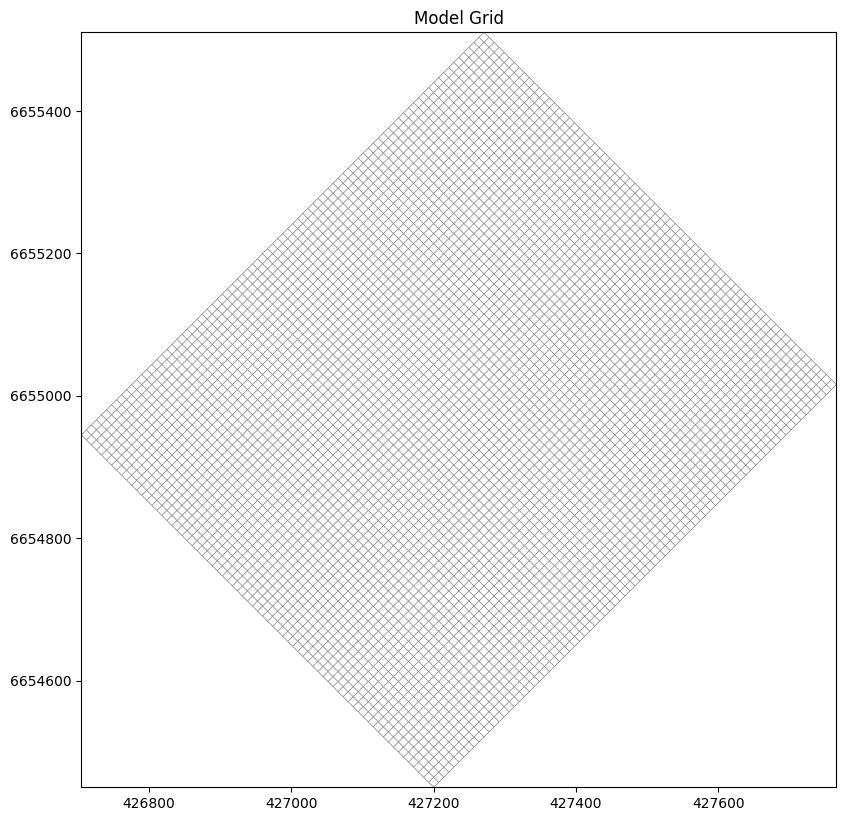

In [6]:
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
mapview = flopy.plot.PlotMapView(model=ml)
linecollection = mapview.plot_grid(lw=0.5)

t = ax.set_title("Model Grid")

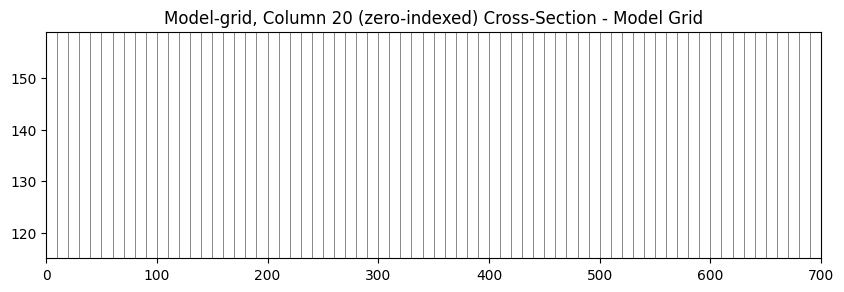

In [7]:
fig = plt.figure(figsize=(10, 3), dpi=100)
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=ml, line={'Column': 20})
plt.ticklabel_format(axis='both', style='plain', useOffset=False)

linecollection = xsect.plot_grid(linewidth=0.5)
t = ax.set_title('Model-grid, Column 20 (zero-indexed) Cross-Section - Model Grid')

### 2.2 Adding topography
Define path to rasters and shapefiles:

In [8]:
raster_pth = os.path.join('..', 'data', 'raw_data', 'rasters')
shapefile_pth = os.path.join('..', 'data', 'raw_data', 'shapefiles')

Load rasters:

In [9]:
top = Raster.load(os.path.join(raster_pth, 'lyr1_top_new_new_new.txt'))
botm = Raster.load(os.path.join(raster_pth, 'botm_new.txt'))
ortophoto = rasterio.open(os.path.join(raster_pth, 'ortophoto.tif'))

Smoothen top raster using a 3x3 kernel:

In [10]:
kernel = np.ones((3,3))
top_smooth = scipy.ndimage.convolve(top.get_array(1), weights=kernel) / kernel.size
top._array[0] = top_smooth

Load shapefiles:

In [11]:
ml_boundary = shapefile.Reader(os.path.join(shapefile_pth, 'model_boundary.shp')) # Model boundary shapefile
mlb_shape = np.array(np.rint(ml_boundary.shapeRecords()[0].shape.points)) # Model boundary array

In [12]:
orbacken = shapefile.Reader(os.path.join(shapefile_pth, 'orbacken_sfr.shp')) # Creek Örbäcken shapefile
orbacken_shp = np.concatenate([np.rint(i.shape.points) for i in orbacken.shapeRecords()]) # Creek Örbäcken array

Plot GIS-data:

In [13]:
min_elevations = []
max_elevations = []
for raster in [top, botm]:
    data = raster.sample_polygon(mlb_shape, band=raster.bands[0])
    min_elevations.append(np.min(data))
    max_elevations.append(np.max(data))

vmin, vmax = np.min(min_elevations), np.max(max_elevations)

Top elevation: 158.28 m.a.s.l., bottom elevation: 114.54 m.a.s.l.


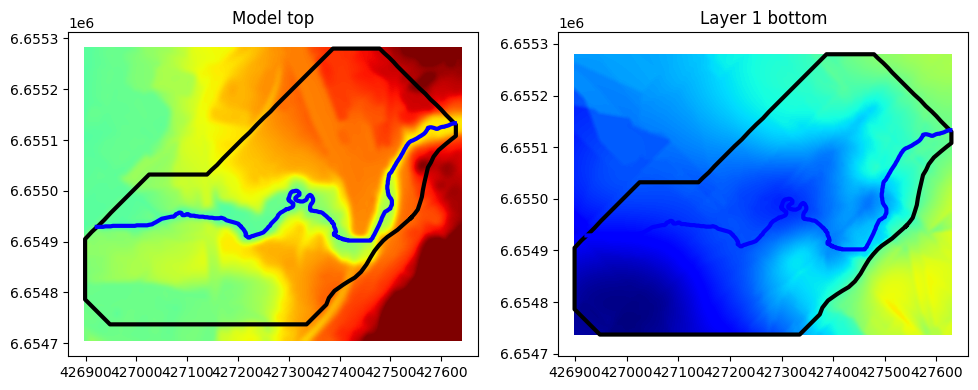

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10,4), dpi=100)
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Plot rasters
top.plot(ax=axs[0], vmin=vmin, vmax=vmax, cmap='jet', aspect='auto')
botm.plot(ax=axs[1], vmin=vmin, vmax=vmax, cmap='jet', aspect='auto')

# Display model boundary
for ax in axs.flat:
    ax.plot(mlb_shape[:,0],mlb_shape[:,1], c='k', lw=3, label='Model boundary')
    ax.plot(orbacken_shp[:,0],orbacken_shp[:,1], c='blue', lw=3, label='Örbäcken')
    ax.axis('equal')

# Set subplot titles
axs[0].set_title('Model top')
axs[1].set_title('Layer 1 bottom')


print(f'Top elevation: {vmax:.2f} m.a.s.l., bottom elevation: {vmin:.2f} m.a.s.l.')
plt.tight_layout()

Define function for applying topography to the base-model grid:

In [15]:
def resample_raster(rasterfile):
    return rasterfile.resample_to_grid(
            ml.modelgrid,
            band=rasterfile.bands[0],
            method="nearest"
        )

Resample raster data:

In [16]:
top_grid = resample_raster(top)
botm_grid = resample_raster(botm)

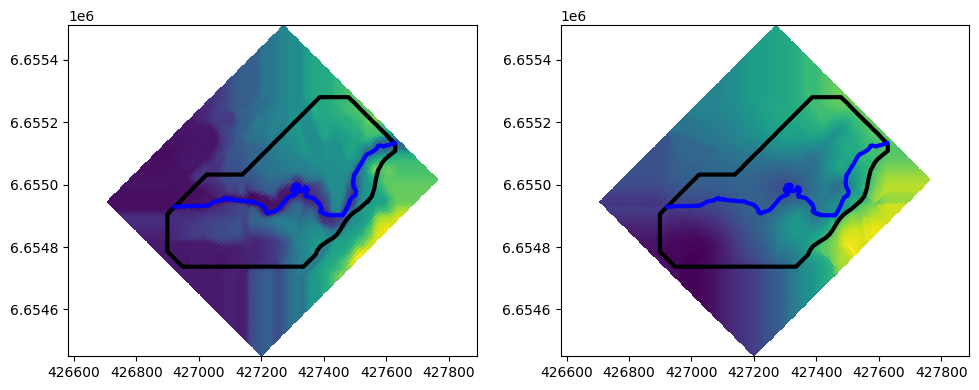

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10,4), dpi=100)

# Display model boundary
for ax in axs.flat:
    ax.plot(mlb_shape[:,0],mlb_shape[:,1], c='k', lw=3, label='Model boundary')
    ax.plot(orbacken_shp[:,0],orbacken_shp[:,1], c='blue', lw=3, label='Örbäcken')
    ax.axis('equal')

pmv1 = flopy.plot.PlotMapView(modelgrid=ml.modelgrid, ax=axs[0])
ax1 = pmv1.plot_array(top_grid)

pmv2 = flopy.plot.PlotMapView(modelgrid=ml.modelgrid, ax=axs[1])
ax2 = pmv2.plot_array(botm_grid)

plt.tight_layout()

(426705.0252531694, 427765.6854249492, 6654450.0, 6655510.66017178)

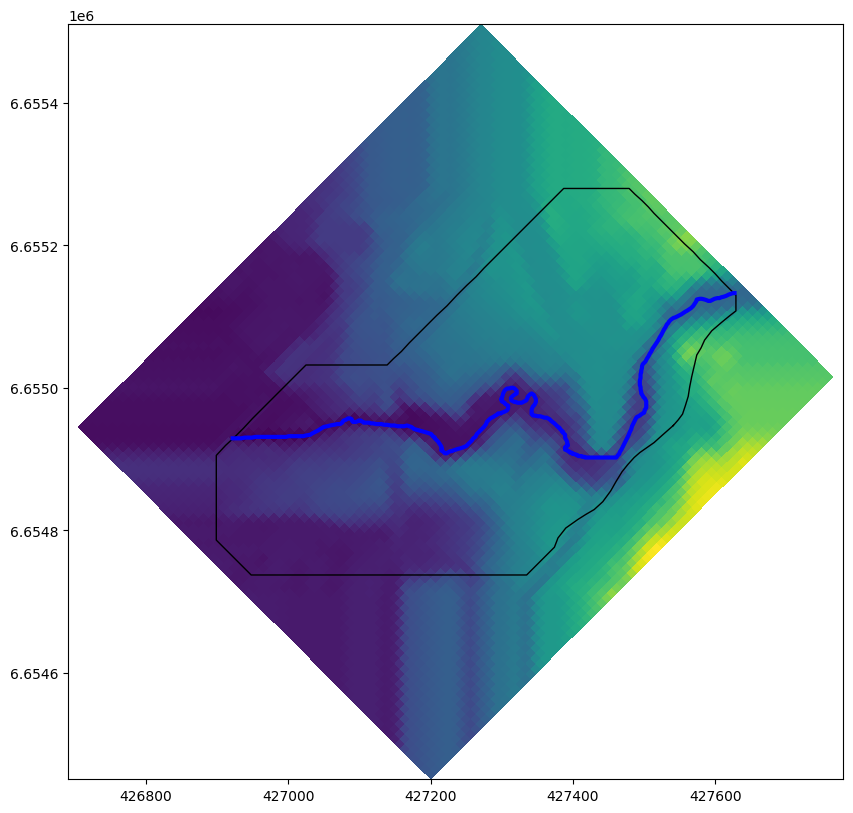

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10,10), dpi=100)
pmv1 = flopy.plot.PlotMapView(modelgrid=ml.modelgrid, ax=ax)
ax1 = pmv1.plot_array(top_grid)
ax.plot(mlb_shape[:,0],mlb_shape[:,1], c='k', lw=1, label='Model boundary')
ax.plot(orbacken_shp[:,0],orbacken_shp[:,1], c='blue', lw=3, label='Örbäcken')
ax.axis('equal')

Assign the resampled grids as model layer elevations:

In [19]:
ml.dis.top = top_grid
ml.dis.botm = botm_grid

Plot cross section to verify model-grid resampling:

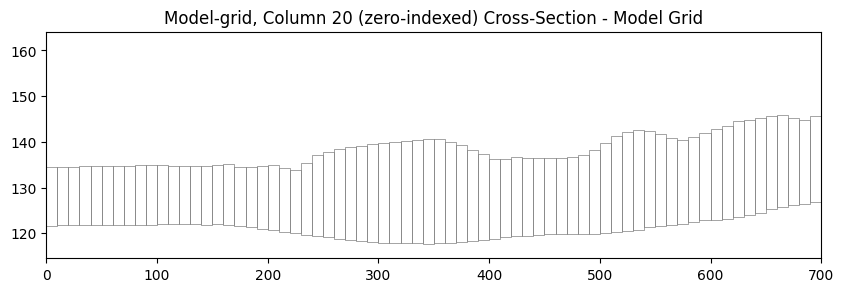

In [20]:
fig = plt.figure(figsize=(10, 3), dpi=100)
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=ml, line={'Column': 20})
plt.ticklabel_format(axis='both', style='plain', useOffset=False)

linecollection = xsect.plot_grid(linewidth=0.5)
t = ax.set_title('Model-grid, Column 20 (zero-indexed) Cross-Section - Model Grid')

## 2.3 Build unstructed grid using GRIDGEN

Instantiate a gridgen object to convert the structured grid (DIS) into a refined unstructured grid (DISV):

In [21]:
g = Gridgen(
    ml.dis,
    model_ws=temp_gridgen_ws,
    exe_name=os.path.join(bins_pth, 'gridgen.exe')
)

C:\Users\nat12nho\AppData\Local\Programs\Python\Python310\lib\site-packages\flopy\utils\gridgen.py:228: UserWarning: Supplying a dis object is deprecated, and support will be removed in version 3.3.7. Please supply StructuredGrid.
  warnings.warn(


Add active domain in order to inactivate cells outside of model boundary:

In [22]:
g.add_active_domain([[np.rint(ml_boundary.shapeRecords()[0].shape.points)]], range(nlay))

Refine model grid (refinement level 1 - this could be refined further when a suitable workflow is determined) along creek Örbäcken:

In [23]:
g.add_refinement_features(
    [orbacken_shp],  # [[orbacken_shp]] for flopy < 3.3.5
    'line',
    1, #refinement level
    range(nlay)
)

Refine model grid using measured head locations:

In [24]:
headobs = pd.read_csv(os.path.join(observations_pth, 'meas_head_pos.csv'))

In [25]:
g.add_refinement_features(
    [(x, y) for x, y in zip(headobs.x.values, headobs.y.values)],
    'point',
    1, #refinement level
    range(nlay)
)

Build model grid:

In [26]:
g.build(verbose=False)

In [27]:
print(f'Number of cells in grid: {g.get_nodes()}')

Number of cells in grid: 3040


Plot model grid:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Gridgen result')

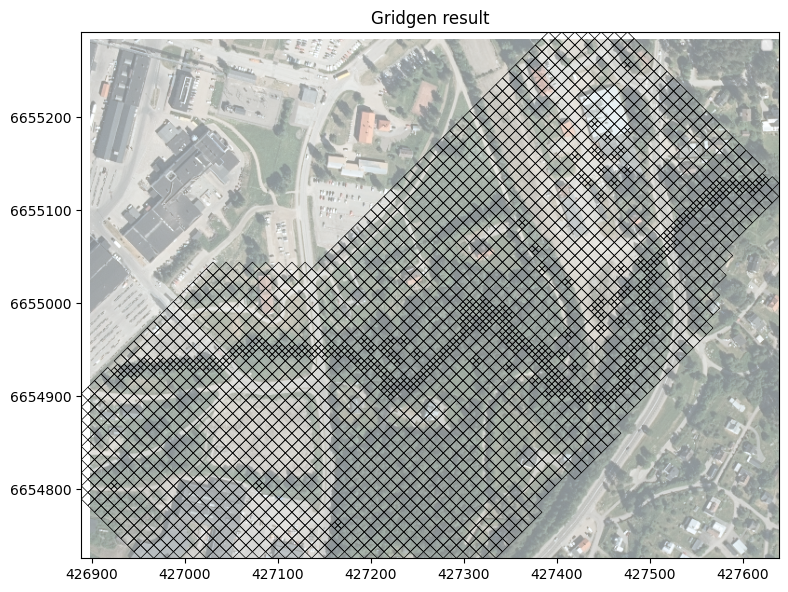

In [28]:
fig = plt.figure(figsize=(9, 9), dpi=100)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
g.plot(ax, linewidth=0.5)
#plt.scatter(headobs.x.values, headobs.y.values, color='blue', s=[10 for i in headobs.x.values], label='Measured head')
rasterio.plot.show(ortophoto.read(), transform=ortophoto.transform, ax=ax, alpha=0.5)
plt.legend()
plt.title('Gridgen result')

## 2.4 Instantiate a MF6 unstructured grid (DISV)
Extract the Grid Properties:

In [29]:
gridprops = g.get_gridprops_disv()

In [30]:
ncpl_gp = gridprops['ncpl']
top_gp = gridprops['top']
botm_gp = gridprops['botm']
nvert_gp = gridprops['nvert']
vertices_gp = gridprops['vertices']
cell2d_gp = gridprops['cell2d']

Cleanup temporary gridgen directory:

In [31]:
if os.path.exists(temp_gridgen_ws):
    shutil.rmtree(temp_gridgen_ws)

Setup MODFLOW simulation package:

In [32]:
sim = flopy.mf6.MFSimulation(
    sim_name = ml_name,
    version = 'mf6',
    exe_name = os.path.join(bins_pth, 'mf6'), 
    sim_ws = ml_ws,
    continue_ = True
)
# By including the CONTINUE flag, MODFLOW 6 will continue its simulation to the end,
# regardless of failure to achieve solution convergence during any particular time step.
# While this may affect the quality of finite-difference derivatives, PEST execution will not be interrupted.

Setup temporal discretization package:

In [33]:
tdis = flopy.mf6.modflow.mftdis.ModflowTdis(
    sim,
    pname = 'tdis',
    time_units = 'DAYS',
    start_date_time = '2015-11-30',
    nper = 2,
    perioddata = [
        (1.0, 1, 1.0), # Steady state period
        ( # Transient stress period
            (365 * 4) + 31, # Length of a stress period (four years + one month)
            (52 * 4) + 4, # The number of time steps in a stress period (one for each week)
            1.0
        )
    ]
)
# 1460 + 30 = 4 * 365 + 31 (December 2015)
# 4 * 52 = Four years * 52 weeks + 4 weeks (December 2015)

Setup groundwater flow package:

In [34]:
gwf = flopy.mf6.ModflowGwf(
    sim,
    modelname=ml_name,
    model_nam_file='{}.nam'.format(ml_name),
    newtonoptions ='under_relaxation'
)

gwf.name_file.save_flows = True

Setup iterative model solution package:

In [35]:
ims = flopy.mf6.ModflowIms( # The following settings allow SFR to converge (default settings won't)
    sim,                    
    pname='ims',
    print_option='SUMMARY',
    complexity='SIMPLE',
    outer_dvclose = 1e-4,
    outer_maximum = 750,
    inner_maximum = 50,
    inner_dvclose = 1e-5,
    linear_acceleration = 'bicgstab'  
)
sim.register_ims_package(ims, [ml_name])

Setup the model grid package with properties extracted from GRIDGEN earlier:

In [36]:
disv = flopy.mf6.ModflowGwfdisv(
    gwf,
    nlay=nlay,
    ncpl=ncpl_gp, 
    top=top_gp,
    botm=botm_gp,
    nvert=nvert_gp,
    vertices=vertices_gp,
    cell2d=cell2d_gp,
    length_units='METERS',
    filename='{}.disv'.format(ml_name)
)

In [37]:
gwf.modelgrid.set_coord_info(proj4='ESPG:3006')
gwf.modelgrid

xll:0.0; yll:0.0; rotation:0.0; proj4_str:ESPG:3006; units:meters; lenuni:2

Setup initial conditions package:

In [38]:
ic = flopy.mf6.ModflowGwfic(
    gwf, pname='ic',
    strt=138.0,
    filename='{}.ic'.format(ml_name)
)

Setup node property flow package:

In [39]:
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    pname='npf',
    save_flows=True,
    icelltype=1,
    k=86.4,
    k33=8.64
)

Setup output control package:

In [40]:
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    pname='oc',
    budget_filerecord='{}.cbb'.format(ml_name),
    head_filerecord='{}.hds'.format(ml_name),
    headprintrecord=[('COLUMNS', 10, 'WIDTH', 15, 'DIGITS', 6, 'GENERAL')],
    saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
    printrecord=[('HEAD', 'FIRST'), ('HEAD', 'LAST'), ('BUDGET', 'LAST')]
)

Setup storage package:

In [41]:
sy = flopy.mf6.ModflowGwfsto.sy.empty(gwf, layered=False)

sy['data'] = 0.2
    
ss = flopy.mf6.ModflowGwfsto.ss.empty(
    gwf,
    layered=False,
    default_value=0.000001
)

sto = flopy.mf6.ModflowGwfsto(
    gwf, pname='sto',
    save_flows=True,
    iconvert=1, 
    ss=ss, sy=sy,
    steady_state={0:True},
    transient={1:True}
)

# 3 Setup boundary conditions
Linear BCs will be setup using the GridIntersect tool, which enable interaction with the model grid in a GIS-like manner:

In [43]:
gwf.modelgrid

xll:0.0; yll:0.0; rotation:0.0; proj4_str:ESPG:3006; units:meters; lenuni:2

In [44]:
ix = GridIntersect(gwf.modelgrid)

## 3.1 General head boundary condition (GHB)

In order to avoid using an excessive amount of shapefiles, lines used for intersecting the model grid are created using numpy and shapely:

In [45]:
d=deque(mlb_shape)
d.rotate(39) # Rotate model boundary lineaments 10 positions (shapefile specific value)
mlb_corr = np.array(d)
mlb_corr = np.insert(mlb_corr, len(mlb_corr), mlb_corr[0], axis=0) # Add extra point at beginning of shp

In [46]:
line1 = mlb_corr[:25]
line2 = mlb_corr[24:62]
line3 = mlb_corr[61:93]
line4 = mlb_corr[92:]

ghb_locations = [line1, line2, line3, line4]
boundnames = ['red', 'yellow', 'green', 'blue']

Plot the lines ontop of the model grid. These will be used to intersect the grid and apply GHB boundary condition (boundnames will be the same as the color to facilitate cell identification in post processing):

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


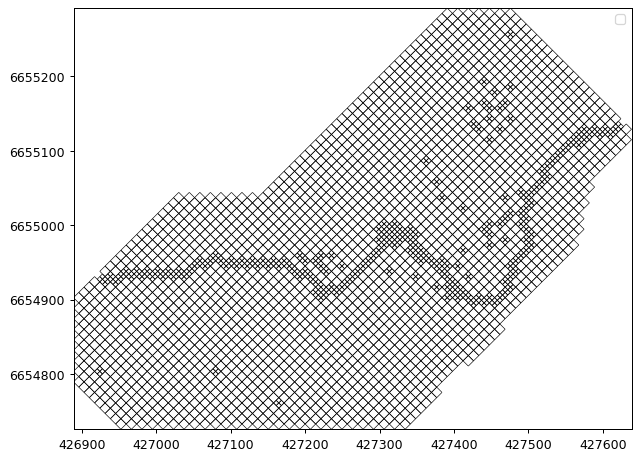

In [51]:
fig = plt.figure(figsize=(8, 8), dpi=90)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
#ax.set_title('General Head Boundary (GHB) Locations', fontsize=18)

#pmv2 = flopy.plot.PlotMapView(modelgrid=ml.modelgrid, ax=ax)
#pmv2.plot_array(botm_grid)

# use PlotMapView to plot a DISV (vertex) model
mapview = flopy.plot.PlotMapView(gwf, layer=0)
linecollection = mapview.plot_grid(lw=0.5, color='black')

#for line, color in zip(ghb_locations, boundnames):
#    plt.plot(line.T[0], line.T[1], color=color, lw=2, label=color)
    
plt.legend()
plt.show()

Construct a dictionary containing data that will be used for the GHB package during the initial run (pre-PEST):

In [54]:
ghb_cells = {
    'cell_id': [],
    'bhead': [],
    'cond': [],
    'boundname': [],
}

Intersect the model grid using the lines shown above and append corresponding cell id and boundname:

In [55]:
for line, color in zip(ghb_locations, boundnames):
    GHB_intersect = LineString(line)
    GHB_cells = ix.intersect(GHB_intersect)

    ghb_cells['cell_id'].append(GHB_cells.cellids)
    
    for cell in range(len(GHB_cells)):
        ghb_cells['boundname'].append(color)

Concatenate arrays of cell ids into a single array and prepend layer number to cell ids:

In [56]:
ghb_cells['cell_id'] = np.concatenate(ghb_cells['cell_id']).ravel() # Concatenate arrays of cell ids
ghb_cells['cell_id'] = [(0, i) for i in ghb_cells['cell_id']] # Prepend layer number (Zero indexed)

Append hydraulic conductivity initial guess (86.4 m/day) to all GHB BCs:

In [57]:
ghb_cells['cond'] = [86.4 for i in range(len(ghb_cells['cell_id']))]

Define a dictionary that contain boundary head initial guess for each boundname (to be adjusted by PEST during history matching):

In [58]:
initial_ghb_bheads = {
    'red': 142.5,
    'yellow': 140.,
    'green': 133.5,
    'blue': 136.5,
}

Append initial boundary head to corresponding cells:

In [59]:
for cell, bname in zip(ghb_cells['cell_id'], ghb_cells['boundname']):
    for color, bhead in initial_ghb_bheads.items():
        if bname == color:
            ghb_cells['bhead'].append(bhead)

Display the data that will be used to construct the GHB package:

In [60]:
ghb_df = pd.DataFrame(ghb_cells)
display(ghb_df)

cell_id  bhead  cond boundname
0    (0, 343)  142.5  86.4       red
1    (0, 344)  142.5  86.4       red
2    (0, 427)  142.5  86.4       red
3    (0, 428)  142.5  86.4       red
4    (0, 503)  142.5  86.4       red
..        ...    ...   ...       ...
241  (0, 339)  136.5  86.4      blue
242  (0, 340)  136.5  86.4      blue
243  (0, 341)  136.5  86.4      blue
244  (0, 342)  136.5  86.4      blue
245  (0, 343)  136.5  86.4      blue

[246 rows x 4 columns]

Drop rows that contain the same cell id (overlapping BCs):

In [61]:
ghb_df.drop_duplicates(subset=['cell_id'], keep='first', inplace=True)

In [62]:
ghb_df.reset_index(drop=True, inplace=True)

Ensure that bheads are >= cell bottom:

In [63]:
bhead_updated = []
for cid, head in zip(ghb_df['cell_id'], ghb_df['bhead']):
    if head < disv.botm.data[0][cid[1]]:
        bhead_updated.append(disv.botm.data[0][cid[1]])
    else:
        bhead_updated.append(head)

In [64]:
ghb_df['bhead'] = bhead_updated

Construct the GHB package, adding a multiplier column for adjustment by PEST:

In [65]:
ghb_spd = []

In [66]:
for index, row in ghb_df.iterrows():
    ghb_spd.append([row['cell_id'], row['bhead'], row['cond'], 1.0, row['boundname']])

In [67]:
ghb_spd = {0: ghb_spd}

In [68]:
ghb_spd

{0: [[(0, 343), 142.5, 86.4, 1.0, 'red'],
  [(0, 344), 142.5, 86.4, 1.0, 'red'],
  [(0, 427), 142.5, 86.4, 1.0, 'red'],
  [(0, 428), 142.5, 86.4, 1.0, 'red'],
  [(0, 503), 142.5, 86.4, 1.0, 'red'],
  [(0, 504), 142.5, 86.4, 1.0, 'red'],
  [(0, 583), 142.5, 86.4, 1.0, 'red'],
  [(0, 584), 142.5, 86.4, 1.0, 'red'],
  [(0, 664), 142.5, 86.4, 1.0, 'red'],
  [(0, 665), 142.5, 86.4, 1.0, 'red'],
  [(0, 746), 142.5, 86.4, 1.0, 'red'],
  [(0, 747), 142.5, 86.4, 1.0, 'red'],
  [(0, 829), 142.5, 86.4, 1.0, 'red'],
  [(0, 830), 142.5, 86.4, 1.0, 'red'],
  [(0, 913), 142.5, 86.4, 1.0, 'red'],
  [(0, 999), 142.5, 86.4, 1.0, 'red'],
  [(0, 1081), 142.5, 86.4, 1.0, 'red'],
  [(0, 1165), 142.5, 86.4, 1.0, 'red'],
  [(0, 1254), 142.5, 86.4, 1.0, 'red'],
  [(0, 1348), 142.5, 86.4, 1.0, 'red'],
  [(0, 1435), 142.5, 86.4, 1.0, 'red'],
  [(0, 1533), 142.5, 86.4, 1.0, 'red'],
  [(0, 1627), 142.5, 86.4, 1.0, 'red'],
  [(0, 1744), 142.5, 86.4, 1.0, 'red'],
  [(0, 1827), 142.5, 86.4, 1.0, 'red'],
  [(0, 1900),

In [69]:
ghb = flopy.mf6.modflow.mfgwfghb.ModflowGwfghb(
    gwf,
    print_input=True,
    print_flows=True,
    save_flows=True,
    auxiliary='MULTIPLIER',
    auxmultname='MULTIPLIER',
    boundnames=True, 
    pname='ghb',
    stress_period_data=ghb_spd
)

In [70]:
def apply_ghb_multiplier():
    df = pd.DataFrame(ghb.stress_period_data.array[0])
    
    # Get number of cells in for each of the bounds that we want to parameterize
    len_yellow = len(df.loc[df['boundname'] == 'yellow']) # Number of cells in yellow GHB cells
    len_blue = len(df.loc[df['boundname'] == 'blue']) # Number of cells in yellow GHB cells
    len_green = len(df.loc[df['boundname'] == 'green']) # Number of cells in yellow GHB cells
    
    # Linear interpolation. Suggested parval1: 0.01, parubnd: 0.9, parlbnd:0.001
    yellow_multiplier = np.linspace(1, 0.01, len_yellow)
    blue_multiplier = np.linspace(1, 0.01, len_blue)
    green_multiplier = np.linspace(1, 0.01, len_green)[::-1] # Flip it
    
    # Change data
    df.loc[df['boundname'] == 'yellow', 'MULTIPLIER'] = yellow_multiplier
    df.loc[df['boundname'] == 'blue', 'MULTIPLIER'] = blue_multiplier
    df.loc[df['boundname'] == 'green', 'MULTIPLIER'] = green_multiplier
    
    return {0: df.to_records(index=False)}

In [71]:
ghb.stress_period_data = apply_ghb_multiplier()

### Construct GHB pilot points for parameterization
This isn't really part of the base model setup. However, since we already have the GHB shapefile (including coordinates) imported, we might as well construct the pilot points-file and template file to avoid unneccesary work further down the line.

In [72]:
x = [line.T[0] for line in ghb_locations]
y = [line.T[1] for line in ghb_locations]

In [73]:
bnames = []
for name, i in zip(boundnames, x):
    for j in range(len(i)):
        bnames.append(name)

In [74]:
x = [item for sublist in x for item in sublist]
y = [item for sublist in y for item in sublist]

In [75]:
initcond = [86.4 for i in range(len(x))]
multiplier = [1.0 for i in range(len(x))]

In [76]:
ghb_pps = pd.DataFrame({'x': x, 'y': y, 'cond': initcond, 'multiplier': multiplier, 'bnames': bnames})
ghb_pps = ghb_pps.drop_duplicates(subset=['x', 'y'], keep='first').reset_index(drop=True)
len(ghb_pps)

129

Reduce the number of pps by half (we don't need a pilot point in every single cell):

In [77]:
ghb_pps = ghb_pps[::2].reset_index(drop=True)

Plot pilot points:

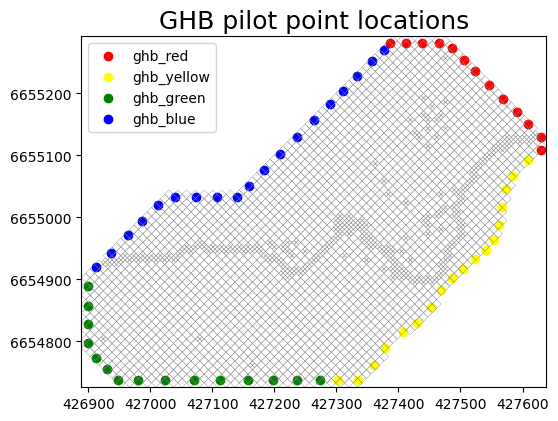

In [78]:
fig = plt.figure(figsize=(6, 6), dpi=100)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
ax.set_title('GHB pilot point locations', fontsize=18)

mapview = flopy.plot.PlotMapView(gwf, layer=0)
linecollection = mapview.plot_grid(lw=0.25)

for bname in ghb_pps['bnames'].unique():
    df = ghb_pps.loc[ghb_pps['bnames'] == bname]
    x = [float(i) for i in df.x.values]
    y = [float(i) for i in df.y.values]
    
    plt.scatter(x, y, color=bname, label=f'ghb_{bname}')

plt.legend()
plt.show()

In [79]:
ghb_pps.insert(0, 'name', ghb_pps.index + 1)

In [80]:
display(ghb_pps)

name         x          y  cond  multiplier bnames
0      1  427387.0  6655280.0  86.4         1.0    red
1      2  427412.0  6655280.0  86.4         1.0    red
2      3  427438.0  6655280.0  86.4         1.0    red
3      4  427466.0  6655280.0  86.4         1.0    red
4      5  427487.0  6655272.0  86.4         1.0    red
..   ...       ...        ...   ...         ...    ...
60    61  427289.0  6655182.0  86.4         1.0   blue
61    62  427311.0  6655204.0  86.4         1.0   blue
62    63  427334.0  6655227.0  86.4         1.0   blue
63    64  427358.0  6655251.0  86.4         1.0   blue
64    65  427377.0  6655270.0  86.4         1.0   blue

[65 rows x 6 columns]

In [81]:
ghb_pps.to_csv(os.path.join(ml_ws, 'pps_ghb.dat'), index=False, header=None, sep='\t')

Create a template file:

In [82]:
import copy
ghb_pps_tpl = copy.deepcopy(ghb_pps)

All pilot points will contain parameters for conductance, but only the red and green boundaries (northeastern and southwestern) will contain parameters for multipliers. Multipliers for the blue and green GHBs will be parameterized using a linear interpolation approach (notebook 3 - parameterization).

In [83]:
for bname in ghb_pps_tpl.bnames.unique():
    ghb_pps_tpl.loc[ghb_pps_tpl['bnames'] == bname, 'cond'] = [f'$ghbc{bname[:3]}pp{i + 1:02d}$' for i in range(len(ghb_pps_tpl.loc[ghb_pps_tpl.bnames == bname]))]

In [84]:
ghb_pps_tpl.head()

name         x          y           cond  multiplier bnames
0     1  427387.0  6655280.0  $ghbcredpp01$         1.0    red
1     2  427412.0  6655280.0  $ghbcredpp02$         1.0    red
2     3  427438.0  6655280.0  $ghbcredpp03$         1.0    red
3     4  427466.0  6655280.0  $ghbcredpp04$         1.0    red
4     5  427487.0  6655272.0  $ghbcredpp05$         1.0    red

In [85]:
ghb_pps_tpl.to_csv(os.path.join(ml_ws, 'pps_ghb.tpl'), index=False, header=None, sep='\t')

In [86]:
def prepend_line(filename, line):
    with open(filename, 'r+') as f:
        content = f.read()
        f.seek(0, 0)
        f.write(line.rstrip('\r\n') + '\n' + content)

In [87]:
prepend_line(os.path.join(ml_ws, 'pps_ghb.tpl'), 'ptf $')

## Recharge

In [88]:
recharge_initial_guess = 200 / 1000 / 365 # 200 mm year ~~ 0.00054 m/day

In [89]:
non_ghb_cells = [i[1] for i in ghb_df['cell_id']]

In [90]:
rchcells = np.array(list(range(gridprops['ncpl'])), dtype=int)
rchcells[non_ghb_cells] = -1
rch_spd = [
    ((0, rchcells[i]), recharge_initial_guess, 1, 'rch') for i in range(ncpl_gp) if rchcells[i] > 0
]
rch_spd = {0: rch_spd}

In [91]:
rch_spd # cellid, recharge, multiplier, boundname

{0: [((0, 23), 0.0005479452054794521, 1, 'rch'),
  ((0, 24), 0.0005479452054794521, 1, 'rch'),
  ((0, 25), 0.0005479452054794521, 1, 'rch'),
  ((0, 26), 0.0005479452054794521, 1, 'rch'),
  ((0, 27), 0.0005479452054794521, 1, 'rch'),
  ((0, 28), 0.0005479452054794521, 1, 'rch'),
  ((0, 29), 0.0005479452054794521, 1, 'rch'),
  ((0, 30), 0.0005479452054794521, 1, 'rch'),
  ((0, 31), 0.0005479452054794521, 1, 'rch'),
  ((0, 32), 0.0005479452054794521, 1, 'rch'),
  ((0, 33), 0.0005479452054794521, 1, 'rch'),
  ((0, 34), 0.0005479452054794521, 1, 'rch'),
  ((0, 35), 0.0005479452054794521, 1, 'rch'),
  ((0, 36), 0.0005479452054794521, 1, 'rch'),
  ((0, 37), 0.0005479452054794521, 1, 'rch'),
  ((0, 38), 0.0005479452054794521, 1, 'rch'),
  ((0, 39), 0.0005479452054794521, 1, 'rch'),
  ((0, 40), 0.0005479452054794521, 1, 'rch'),
  ((0, 41), 0.0005479452054794521, 1, 'rch'),
  ((0, 42), 0.0005479452054794521, 1, 'rch'),
  ((0, 43), 0.0005479452054794521, 1, 'rch'),
  ((0, 44), 0.00054794520547945

In [92]:
rch = flopy.mf6.ModflowGwfrch(
    gwf,
    filename='{}.rch'.format(ml_name),
    stress_period_data=rch_spd,
    pname='rch',
    auxiliary='MULTIPLIER',
    auxmultname='MULTIPLIER',
    boundnames=True,
    print_input=True,
    print_flows=True, 
    save_flows=True,
    fixed_cell=True,
)

## 3.3 Streamflow routing boundary condition (SFR)

The SFR package is an advanced MODFLOW package that needs five types of data. These are `DIMENSION`, `PACKAGEDATA`, `CONNECTIONDATA`, `DIVERSIONS` and `PERIOD` data. `DIMENSION` is simply the number of reaches that are defined in the SFR package. Details of the `PACKAGEDATA` are specified below (this is the labor intensive part of SFR):

- rno = Reach number, a unique number for each cell
- cellid = Model cell ID, a unique number, for the corresponding reach number
- rlen = real value that defines the reach length. RLEN must be greater than zero.
- rwid = real value that defines the reach width. RWID must be greater than zero.
- rgrd: real value that defines the stream gradient (slope) across the reach. RGRD must be greater than zero.
- rtp: real value that defines the top elevation of the reach streambed.
- rbth: real value that defines the thickness of the reach streambed.
- rhk: real value that defines the hydraulic conductivity of the reach streambed.
- man: real or character value that defines the Manning’s roughness coefficient for the reach.
- ncon: integer value that defines the number of reaches connected to the reach.
- ustrf: real value that defines the fraction of upstream flow from each upstream reach that is applied as upstream inflow to the reach.
- ndv: integer value that defines the number of downstream diversions for the reach.
- boundname: name of the stream reach cell.

`CONNECTIONDATA` specifies which reaches are connected with eachother. This is fairly simple to script.

`DIVERSIONS` can be omitted, because we treat Creek Örbäcken as a single stream of water.

`PERIOD` Stress period info.

### 3.3.1 Intersect and sample grid data
We will be using a shapefile to intersect the model grid:

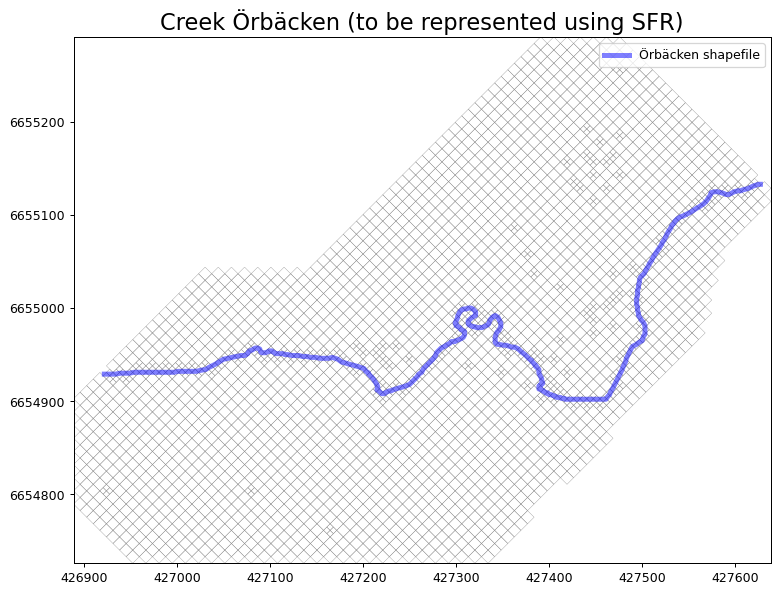

In [93]:
fig = plt.figure(figsize=(10, 10), dpi=90)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
ax.set_title('Creek Örbäcken (to be represented using SFR)', fontsize=18)

# use PlotMapView to plot a DISV (vertex) model
mapview = flopy.plot.PlotMapView(gwf, layer=0)
linecollection = mapview.plot_grid(lw=0.25)

# Display model boundary
ax.plot(orbacken_shp[:,0],orbacken_shp[:,1], c='blue', lw=4, alpha=0.5, label='Örbäcken shapefile')
    
plt.legend()
plt.show()

Intersect the model grid using orbacken_shp:

In [94]:
ORB_intersect = LineString(orbacken_shp)

Obtain cell information:

In [95]:
ORB_cells = ix.intersect(ORB_intersect)

Show sampled information using pandas. As we can see, we can extract `nreaches` from `len(df)`, `rno` from `df.index`, `cellid` from `cellids` and `rlen` from `lengths`:

In [96]:
df = pd.DataFrame(ORB_cells)
display(df)

cellids                                           vertices   lengths  \
0         4  ((426926.0609766315, 6654929.0), (426926.0, 66...  3.665230   
1         5  ((426929.4668147354, 6654929.0), (426926.06097...  3.405838   
2        27  ((426933.1320443483, 6654929.0), (426930.0, 66...  3.665230   
3        30  ((426937.1723533241, 6654929.634470665), (4269...  4.103134   
4        32  ((426939.20311209204, 6654930.0), (426939.0, 6...  2.066953   
..      ...                                                ...       ...   
258    2928  ((427461.47114062397, 6654902.706710936), (427...  6.742577   
259    2929  ((427464.624459691, 6654906.624459691), (42746...  5.053523   
260    2932  ((427466.9279948907, 6654911.391992336), (4274...  5.366338   
261    2933  ((427469.4636850218, 6654915.9273700435), (427...  5.205484   
262    2936  ((427470.9898888184, 6654918.979777637), (4274...  3.412695   

                                              ixshapes  
0    LINESTRING (426926.0609766315 6654929, 426926 ...  
1    LINESTRING (426929.4668147354 6654929, 426926....  
2    LINESTRING (426933.1320443483 6654929, 426930 ...  
3    LINESTRING (426937.1723533241 6654929.63447066...  
4    LINESTRING (426939.20311209204 6654930, 426939...  
..                                                 ...  
258  LINESTRING (427461.47114062397 6654902.7067109...  
259  LINESTRING (427464.624459691 6654906.624459691...  
260  LINESTRING (427466.9279948907 6654911.39199233...  
261  LINESTRING (427469.4636850218 6654915.92737004...  
262  LINESTRING (427470.9898888184 6654918.97977763...  

[263 rows x 4 columns]

In order to obtain streambed elevation data (rtp), we can sample the digital elevation map (DEM) using the intersected cells.

To get the best representation of streambed elevations, we create a list of points at the center of each SFR-cell, and use these points to sample the DEM raster file.

Let's start by creating the points and plotting their position ontop of the model grid:

In [97]:
sfr_centerpoints = [[gwf.modelgrid.xcellcenters[i], gwf.modelgrid.ycellcenters[i]] for i in df.cellids.values]
sfr_centerpoints = np.array(sfr_centerpoints) # Turn it into a numpy array

We can see that the points are located where we expect them to be. However, the **order** of certain points have been misrepresented during grid intersection!

**This presents an issue**, since the streamflow routing package requires reach connection data for each cell in a continuous manner. In the case of creek Örbäcken, we want to represent streamflow from NE to SW. The current order of points will produce an erroneous representation of streamflow in the creek:

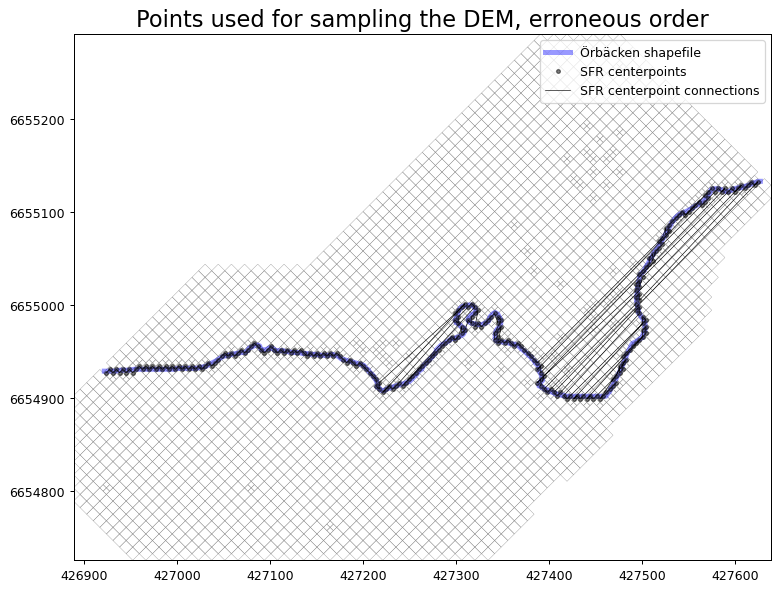

In [98]:
fig = plt.figure(figsize=(10, 10), dpi=90)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
ax.set_title('Points used for sampling the DEM, erroneous order', fontsize=18)

mapview = flopy.plot.PlotMapView(gwf, layer=0)
linecollection = mapview.plot_grid(lw=0.25)

ax.plot(orbacken_shp[:,0],orbacken_shp[:,1], c='blue', lw=4, label='Örbäcken shapefile', alpha=0.4)
ax.plot(sfr_centerpoints[:,0], sfr_centerpoints[:,1], 'k.', alpha=0.5, label='SFR centerpoints')
ax.plot(sfr_centerpoints[:,0], sfr_centerpoints[:,1], lw=0.5, color='black', label='SFR centerpoint connections')
    
plt.legend()
plt.show()

Just to illustrate this problem further we compare the actual length of the creek with the length produced by the unordered list of intersected SFR-cells:

In [99]:
print(f'Creek Örbäcken Shapefile length: {LineString(orbacken_shp).length:.2f} meters')
print(f'Length between (unordered) SFR-cell centerpoints: {LineString(sfr_centerpoints).length:.2f} meters')

Creek Örbäcken Shapefile length: 1068.09 meters
Length between (unordered) SFR-cell centerpoints: 4628.25 meters


However, it appears that the total length of intersected line segments sums up to the expected length of the creek. This is great, because it is a verification that the intersected cell data is usable **as long as the order is corrected**:

In [100]:
print(f'Length of intersected line segments: {sum(df.lengths.values):.2f} meters')

Length of intersected line segments: 1067.69 meters


So before we fix the order, lets discuss why this happened. Well, the current best guess is that a combination of grid orientation in relation to the creek **and** the size of the creek (hence size of bounding box) in relation to the model grid caused the spatial indexing method used by Shapely (Flopy uses Shapely (which in turn use GEOS) in the background for grid intersections) to be confused.

A Voronoi grid would likely not be affected by this issue.

OK. Lets fix the order of the points. The following solution is a modification of a method presented in this Stackoverflow issue: https://stackoverflow.com/questions/37742358/sorting-points-to-form-a-continuous-line

Lets define the function:

In [101]:
def order_points(points, ind):
    points = [ tuple(point) for point in points ] # transform array of arrays into array of points
    points_new = [ points.pop(ind) ]  # initialize a new list of points with the known first point
    pcurr      = points_new[-1]       # initialize the current point (as the known point)
    while len(points)>0:
        d      = np.linalg.norm(np.array(points) - np.array(pcurr), axis=1)  # distances between pcurr and all other remaining points
        ind    = d.argmin()                   # index of the closest point
        points_new.append( points.pop(ind) )  # append the closest point to points_new
        pcurr  = points_new[-1]               # update the current point
    points_new = np.asarray([np.asarray(point) for point in points_new]) # re-transform array of points into array of arrays
    return points_new

Create an ordered version of the list and visualize:

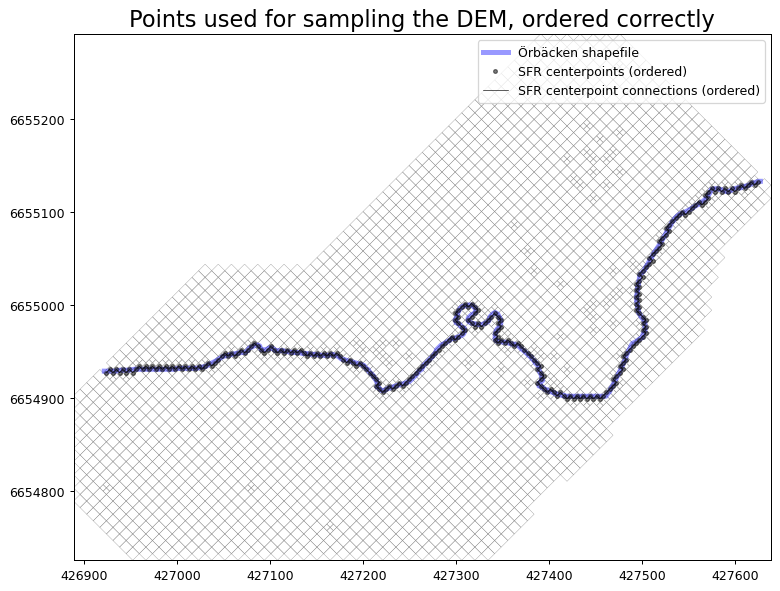

In [102]:
sfr_centerpoints_ordered = order_points(sfr_centerpoints, 0)

fig = plt.figure(figsize=(10, 10), dpi=90)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
ax.set_title('Points used for sampling the DEM, ordered correctly', fontsize=18)

mapview = flopy.plot.PlotMapView(gwf, layer=0)
linecollection = mapview.plot_grid(lw=0.25)

ax.plot(orbacken_shp[:,0],orbacken_shp[:,1], c='blue', lw=4, label='Örbäcken shapefile', alpha=0.4)
ax.plot(sfr_centerpoints_ordered[:,0], sfr_centerpoints_ordered[:,1], 'k.', alpha=0.5, label='SFR centerpoints (ordered)')
ax.plot(sfr_centerpoints_ordered[:,0], sfr_centerpoints_ordered[:,1], lw=0.5, color='black', label='SFR centerpoint connections (ordered)')
    
plt.legend()
plt.show()

The next step is to sort the dataframe containing the intersected cells according to the sorted list. Let's see the DF again:

In [103]:
display(df)

cellids                                           vertices   lengths  \
0         4  ((426926.0609766315, 6654929.0), (426926.0, 66...  3.665230   
1         5  ((426929.4668147354, 6654929.0), (426926.06097...  3.405838   
2        27  ((426933.1320443483, 6654929.0), (426930.0, 66...  3.665230   
3        30  ((426937.1723533241, 6654929.634470665), (4269...  4.103134   
4        32  ((426939.20311209204, 6654930.0), (426939.0, 6...  2.066953   
..      ...                                                ...       ...   
258    2928  ((427461.47114062397, 6654902.706710936), (427...  6.742577   
259    2929  ((427464.624459691, 6654906.624459691), (42746...  5.053523   
260    2932  ((427466.9279948907, 6654911.391992336), (4274...  5.366338   
261    2933  ((427469.4636850218, 6654915.9273700435), (427...  5.205484   
262    2936  ((427470.9898888184, 6654918.979777637), (4274...  3.412695   

                                              ixshapes  
0    LINESTRING (426926.0609766315 6654929, 426926 ...  
1    LINESTRING (426929.4668147354 6654929, 426926....  
2    LINESTRING (426933.1320443483 6654929, 426930 ...  
3    LINESTRING (426937.1723533241 6654929.63447066...  
4    LINESTRING (426939.20311209204 6654930, 426939...  
..                                                 ...  
258  LINESTRING (427461.47114062397 6654902.7067109...  
259  LINESTRING (427464.624459691 6654906.624459691...  
260  LINESTRING (427466.9279948907 6654911.39199233...  
261  LINESTRING (427469.4636850218 6654915.92737004...  
262  LINESTRING (427470.9898888184 6654918.97977763...  

[263 rows x 4 columns]

Append the coordinates of the erroneously ordered centerpoints as a new column:

In [104]:
df['ctp_coord'] = [value for index, value in enumerate(sfr_centerpoints)]
df['ctp_ind'] = [index for index, value in enumerate(sfr_centerpoints)]
display(df.head())

cellids                                           vertices   lengths  \
0       4  ((426926.0609766315, 6654929.0), (426926.0, 66...  3.665230   
1       5  ((426929.4668147354, 6654929.0), (426926.06097...  3.405838   
2      27  ((426933.1320443483, 6654929.0), (426930.0, 66...  3.665230   
3      30  ((426937.1723533241, 6654929.634470665), (4269...  4.103134   
4      32  ((426939.20311209204, 6654930.0), (426939.0, 6...  2.066953   

                                            ixshapes  \
0  LINESTRING (426926.0609766315 6654929, 426926 ...   
1  LINESTRING (426929.4668147354 6654929, 426926....   
2  LINESTRING (426933.1320443483 6654929, 426930 ...   
3  LINESTRING (426937.1723533241 6654929.63447066...   
4  LINESTRING (426939.20311209204 6654930, 426939...   

                                  ctp_coord  ctp_ind  
0   [426924.2283617318, 6654927.2970809955]        0  
1    [426927.7638956851, 6654930.832614854]        1  
2  [426931.29942954367, 6654927.2970809005]        2  
3   [426934.83496349695, 6654930.832614759]        3  
4   [426938.3704973555, 6654927.2970808055]        4

Create a second dataframe using the coordinates of the correctly ordered centerpoints:

In [105]:
df_ordered = pd.DataFrame({'ctp_coord': [value for index, value in enumerate(sfr_centerpoints_ordered)]})
display(df_ordered.head())

ctp_coord
0   [426924.2283617318, 6654927.2970809955]
1    [426927.7638956851, 6654930.832614854]
2  [426931.29942954367, 6654927.2970809005]
3   [426934.83496349695, 6654930.832614759]
4   [426938.3704973555, 6654927.2970808055]

Now we will re-index the original dataframe using the centerpoint coordinates. However, before we can do so, they must first be converted into string datatype:

In [106]:
def coord_as_str(arr):
    return [str(coordinate) for coordinate in arr]

Create string version columns of centerpoint coordinates of both dataframes:

In [107]:
df['ctp_coord_str'] = coord_as_str(df.ctp_coord.values)
df_ordered['ctp_coord_str'] = coord_as_str(df_ordered.ctp_coord.values)

Set the coordinates as dataframe index for the original DF and reindex according the the ordered dataframe:

In [108]:
df = df.set_index('ctp_coord_str')
df = df.reindex(index=df_ordered['ctp_coord_str'])

Reset the index and display the results. By comparing the df.index with df.ctp_ind we can see that the original dataframe has been reordered according to the ordered list of SFR-cells:

In [109]:
df = df.reset_index()
display(df)

ctp_coord_str cellids  \
0    [ 426924.22836173 6654927.297081  ]       4   
1    [ 426927.76389569 6654930.83261485]       5   
2    [ 426931.29942954 6654927.2970809 ]      27   
3    [ 426934.8349635  6654930.83261476]      30   
4    [ 426938.37049736 6654927.29708081]      32   
..                                   ...     ...   
258  [ 427610.12194214 6655125.28697054]    2637   
259  [ 427613.65747609 6655128.8225044 ]    2640   
260  [ 427617.19301004 6655132.35803826]    2641   
261    [ 427620.7285439 6655128.8225043]    2643   
262  [ 427624.26407785 6655132.35803816]    2645   

                                              vertices   lengths  \
0    ((426926.0609766315, 6654929.0), (426926.0, 66...  3.665230   
1    ((426929.4668147354, 6654929.0), (426926.06097...  3.405838   
2    ((426933.1320443483, 6654929.0), (426930.0, 66...  3.665230   
3    ((426937.1723533241, 6654929.634470665), (4269...  4.103134   
4    ((426939.20311209204, 6654930.0), (426939.0, 6...  2.066953   
..                                                 ...       ...   
258  ((427611.15555727994, 6655127.78888932), (4276...  2.841136   
259  ((427616.3436762449, 6655129.671838122), (4276...  5.534985   
260  ((427619.55575856194, 6655131.185252854), (427...  3.555681   
261  ((427621.3149366054, 6655131.771645535), (4276...  1.854336   
262  ((427627.0, 6655133.0), (427625.0, 6655133.0),...  5.884398   

                                              ixshapes  \
0    LINESTRING (426926.0609766315 6654929, 426926 ...   
1    LINESTRING (426929.4668147354 6654929, 426926....   
2    LINESTRING (426933.1320443483 6654929, 426930 ...   
3    LINESTRING (426937.1723533241 6654929.63447066...   
4    LINESTRING (426939.20311209204 6654930, 426939...   
..                                                 ...   
258  LINESTRING (427611.15555727994 6655127.7888893...   
259  LINESTRING (427616.3436762449 6655129.67183812...   
260  LINESTRING (427619.55575856194 6655131.1852528...   
261  LINESTRING (427621.3149366054 6655131.77164553...   
262  LINESTRING (427627 6655133, 427625 6655133, 42...   

                                    ctp_coord  ctp_ind  
0     [426924.2283617318, 6654927.2970809955]        0  
1      [426927.7638956851, 6654930.832614854]        1  
2    [426931.29942954367, 6654927.2970809005]        2  
3     [426934.83496349695, 6654930.832614759]        3  
4     [426938.3704973555, 6654927.2970808055]        4  
..                                        ...      ...  
258    [427610.1219421353, 6655125.286970539]      215  
259   [427613.6574760886, 6655128.8225043975]      216  
260   [427617.19301004196, 6655132.358038256]      217  
261  [427620.72854390054, 6655128.8225043025]      218  
262   [427624.26407785376, 6655132.358038161]      219  

[263 rows x 7 columns]

### 3.3.2 Create SEGFILE for PLPROC parameterization
As with the GHB pilot point setup, this is also not part of the base model setup. However, it is more convenient to create the segfile while the coordinates are available.

Extract coordinates from df:

In [110]:
segfile = df[['ctp_coord']] # Centerpoint coordinate
display(segfile)

ctp_coord
0     [426924.2283617318, 6654927.2970809955]
1      [426927.7638956851, 6654930.832614854]
2    [426931.29942954367, 6654927.2970809005]
3     [426934.83496349695, 6654930.832614759]
4     [426938.3704973555, 6654927.2970808055]
..                                        ...
258    [427610.1219421353, 6655125.286970539]
259   [427613.6574760886, 6655128.8225043975]
260   [427617.19301004196, 6655132.358038256]
261  [427620.72854390054, 6655128.8225043025]
262   [427624.26407785376, 6655132.358038161]

[263 rows x 1 columns]

Split into x, y columns:

In [111]:
segfile['x'], segfile['y'] = zip(*segfile.pop('ctp_coord'))

C:\Users\nat12nho\AppData\Local\Temp\ipykernel_7844\1639070569.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segfile['x'], segfile['y'] = zip(*segfile.pop('ctp_coord'))
C:\Users\nat12nho\AppData\Local\Temp\ipykernel_7844\1639070569.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segfile['x'], segfile['y'] = zip(*segfile.pop('ctp_coord'))


Append seglist column. This should be redone and improved once the a proper number of reaches has been determined through history-matching.

In [112]:
segid = ['r'+str(i + 1)+'s1' for i in range(len(segfile))]

In [113]:
segfile['segid'] = segid
display(segfile)

C:\Users\nat12nho\AppData\Local\Temp\ipykernel_7844\2906567374.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segfile['segid'] = segid


x             y   segid
0    426924.228362  6.654927e+06    r1s1
1    426927.763896  6.654931e+06    r2s1
2    426931.299430  6.654927e+06    r3s1
3    426934.834963  6.654931e+06    r4s1
4    426938.370497  6.654927e+06    r5s1
..             ...           ...     ...
258  427610.121942  6.655125e+06  r259s1
259  427613.657476  6.655129e+06  r260s1
260  427617.193010  6.655132e+06  r261s1
261  427620.728544  6.655129e+06  r262s1
262  427624.264078  6.655132e+06  r263s1

[263 rows x 3 columns]

Write table-protocol segfile for further processing during paramerization:

In [114]:
segfile.to_csv(
    os.path.join(ml_ws, 'sfr_segfile.dat'),
    header=None,
    index=False,
    sep='\t',
    float_format='%.3f'
)

### 3.3.3 Sample the DEM raster for streambed elevations
Now that the dataframe is in order, we can sample the DEM raster for the streambed elevation input parameter.

To do so lets extract the X and Y coordinates from the coordinates column:

In [115]:
x = np.asarray([np.asarray(i) for i in df['ctp_coord'].values])[:,0]
y = np.asarray([np.asarray(i) for i in df['ctp_coord'].values])[:,1]

Create a new column to hold the streambed elevations using the sampled data:

In [116]:
df['rtp'] = [top.sample_point(x[i], y[i], band=1) for i in range(len(x))]

The order of the dataframe now has to be inverted, as the streambed elevation should go from high to low:

In [117]:
df = df.reindex(index=df.index[::-1]).reset_index(drop=True)
display(df) # See rtp column to the right. Values are in meters above sea level.

ctp_coord_str cellids  \
0    [ 427624.26407785 6655132.35803816]    2645   
1      [ 427620.7285439 6655128.8225043]    2643   
2    [ 427617.19301004 6655132.35803826]    2641   
3    [ 427613.65747609 6655128.8225044 ]    2640   
4    [ 427610.12194214 6655125.28697054]    2637   
..                                   ...     ...   
258  [ 426938.37049736 6654927.29708081]      32   
259  [ 426934.8349635  6654930.83261476]      30   
260  [ 426931.29942954 6654927.2970809 ]      27   
261  [ 426927.76389569 6654930.83261485]       5   
262  [ 426924.22836173 6654927.297081  ]       4   

                                              vertices   lengths  \
0    ((427627.0, 6655133.0), (427625.0, 6655133.0),...  5.884398   
1    ((427621.3149366054, 6655131.771645535), (4276...  1.854336   
2    ((427619.55575856194, 6655131.185252854), (427...  3.555681   
3    ((427616.3436762449, 6655129.671838122), (4276...  5.534985   
4    ((427611.15555727994, 6655127.78888932), (4276...  2.841136   
..                                                 ...       ...   
258  ((426939.20311209204, 6654930.0), (426939.0, 6...  2.066953   
259  ((426937.1723533241, 6654929.634470665), (4269...  4.103134   
260  ((426933.1320443483, 6654929.0), (426930.0, 66...  3.665230   
261  ((426929.4668147354, 6654929.0), (426926.06097...  3.405838   
262  ((426926.0609766315, 6654929.0), (426926.0, 66...  3.665230   

                                              ixshapes  \
0    LINESTRING (427627 6655133, 427625 6655133, 42...   
1    LINESTRING (427621.3149366054 6655131.77164553...   
2    LINESTRING (427619.55575856194 6655131.1852528...   
3    LINESTRING (427616.3436762449 6655129.67183812...   
4    LINESTRING (427611.15555727994 6655127.7888893...   
..                                                 ...   
258  LINESTRING (426939.20311209204 6654930, 426939...   
259  LINESTRING (426937.1723533241 6654929.63447066...   
260  LINESTRING (426933.1320443483 6654929, 426930 ...   
261  LINESTRING (426929.4668147354 6654929, 426926....   
262  LINESTRING (426926.0609766315 6654929, 426926 ...   

                                    ctp_coord  ctp_ind         rtp  
0     [427624.26407785376, 6655132.358038161]      219  143.655075  
1    [427620.72854390054, 6655128.8225043025]      218  143.532104  
2     [427617.19301004196, 6655132.358038256]      217  143.535782  
3     [427613.6574760886, 6655128.8225043975]      216  143.494934  
4      [427610.1219421353, 6655125.286970539]      215  143.487442  
..                                        ...      ...         ...  
258   [426938.3704973555, 6654927.2970808055]        4  133.955704  
259   [426934.83496349695, 6654930.832614759]        3  133.658142  
260  [426931.29942954367, 6654927.2970809005]        2  134.483261  
261    [426927.7638956851, 6654930.832614854]        1  134.278702  
262   [426924.2283617318, 6654927.2970809955]        0  135.102982  

[263 rows x 8 columns]

Because SFR require decreasing streambed elevation in the downstream direction, we plot the sampled elevations in the `rtp` column:

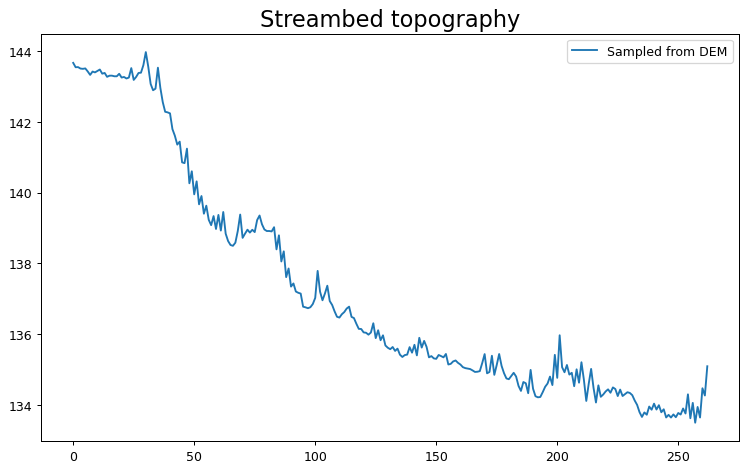

In [118]:
fig = plt.figure(figsize=(10, 6), dpi=90)
ax = fig.add_subplot(1, 1, 1)
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
ax.set_title('Streambed topography', fontsize=18)

plt.plot(df.rtp.values, label='Sampled from DEM')

plt.legend()
plt.show()

As we can see, roughness in the DEM cause upward spikes at different points along the generally decreasing elevation. To fix this we apply a smoothing algorithm (inspired by the SFRMaker package, which at the time of writing unfortunately does not work with DISV grids):

In [119]:
# This can probably be handled with more grace, but it gets the job done
smoothed_sfr_elevation = []
current_min = 0
for count, element in enumerate(df.rtp.values):
    if count == 0:
        smoothed_sfr_elevation.append(element)
        current_min = element
    else:
        if element > current_min:
            new_min = current_min# - 0.0001
            smoothed_sfr_elevation.append(new_min)
            current_min = new_min
        else:
            smoothed_sfr_elevation.append(element)
            current_min = element

Lets compare the smoothened version with the original sampled data:

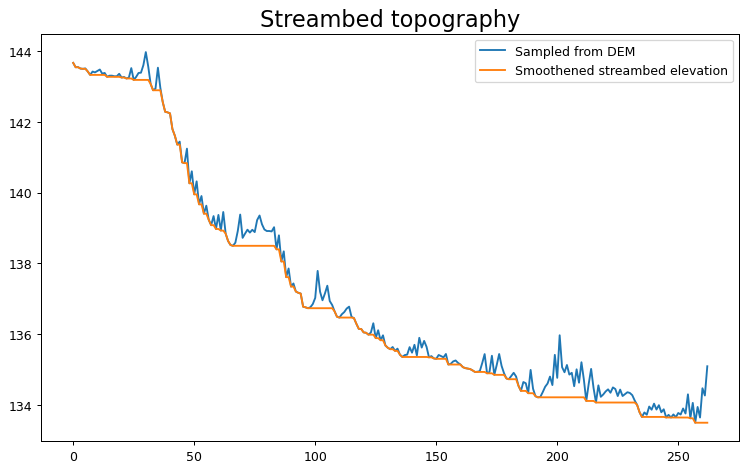

In [120]:
fig = plt.figure(figsize=(10, 6), dpi=90)
ax = fig.add_subplot(1, 1, 1)
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
ax.set_title('Streambed topography', fontsize=18)

plt.plot(df.rtp.values, label='Sampled from DEM')
plt.plot(smoothed_sfr_elevation, label='Smoothened streambed elevation')

plt.legend()
plt.show()

We now have a working model input that SFR will accept. Let's update the `rtp` column with the new values:

In [121]:
df['rtp'] = smoothed_sfr_elevation

Save the updated rtp values to a csv file. This will be used to parameterize rtp in a subsequent step.

In [122]:
df['rtp'].to_csv(os.path.join(ml_ws, 'sfr_rtp_initial.csv'), index=False)

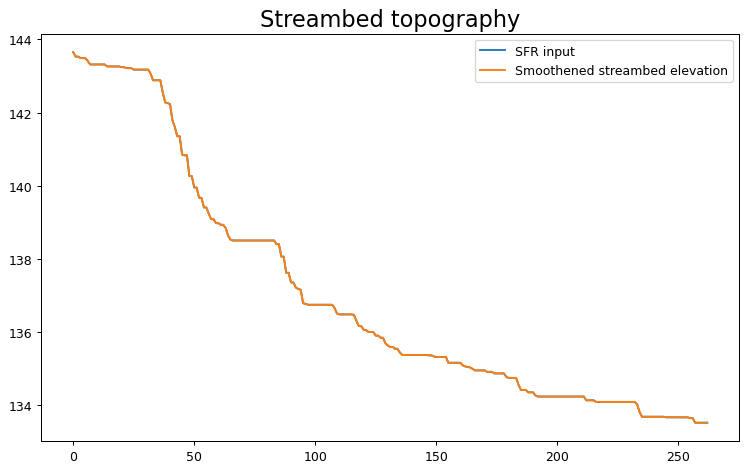

In [123]:
fig = plt.figure(figsize=(10, 6), dpi=90)
ax = fig.add_subplot(1, 1, 1)
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
ax.set_title('Streambed topography', fontsize=18)

plt.plot(df.rtp.values, label='SFR input')
plt.plot(smoothed_sfr_elevation, label='Smoothened streambed elevation')

plt.legend()
plt.show()

### 3.3.4 Assign initial parameter values for stream flow gradient and streambed depth
These initial guesses will be assigned using the streambed top elevation.

In [124]:
df.rtp_smooth = gaussian_filter1d(df.rtp, 5)

C:\Users\nat12nho\AppData\Local\Temp\ipykernel_7844\1814470910.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.rtp_smooth = gaussian_filter1d(df.rtp, 5)


In [125]:
df

ctp_coord_str cellids  \
0    [ 427624.26407785 6655132.35803816]    2645   
1      [ 427620.7285439 6655128.8225043]    2643   
2    [ 427617.19301004 6655132.35803826]    2641   
3    [ 427613.65747609 6655128.8225044 ]    2640   
4    [ 427610.12194214 6655125.28697054]    2637   
..                                   ...     ...   
258  [ 426938.37049736 6654927.29708081]      32   
259  [ 426934.8349635  6654930.83261476]      30   
260  [ 426931.29942954 6654927.2970809 ]      27   
261  [ 426927.76389569 6654930.83261485]       5   
262  [ 426924.22836173 6654927.297081  ]       4   

                                              vertices   lengths  \
0    ((427627.0, 6655133.0), (427625.0, 6655133.0),...  5.884398   
1    ((427621.3149366054, 6655131.771645535), (4276...  1.854336   
2    ((427619.55575856194, 6655131.185252854), (427...  3.555681   
3    ((427616.3436762449, 6655129.671838122), (4276...  5.534985   
4    ((427611.15555727994, 6655127.78888932), (4276...  2.841136   
..                                                 ...       ...   
258  ((426939.20311209204, 6654930.0), (426939.0, 6...  2.066953   
259  ((426937.1723533241, 6654929.634470665), (4269...  4.103134   
260  ((426933.1320443483, 6654929.0), (426930.0, 66...  3.665230   
261  ((426929.4668147354, 6654929.0), (426926.06097...  3.405838   
262  ((426926.0609766315, 6654929.0), (426926.0, 66...  3.665230   

                                              ixshapes  \
0    LINESTRING (427627 6655133, 427625 6655133, 42...   
1    LINESTRING (427621.3149366054 6655131.77164553...   
2    LINESTRING (427619.55575856194 6655131.1852528...   
3    LINESTRING (427616.3436762449 6655129.67183812...   
4    LINESTRING (427611.15555727994 6655127.7888893...   
..                                                 ...   
258  LINESTRING (426939.20311209204 6654930, 426939...   
259  LINESTRING (426937.1723533241 6654929.63447066...   
260  LINESTRING (426933.1320443483 6654929, 426930 ...   
261  LINESTRING (426929.4668147354 6654929, 426926....   
262  LINESTRING (426926.0609766315 6654929, 426926 ...   

                                    ctp_coord  ctp_ind         rtp  
0     [427624.26407785376, 6655132.358038161]      219  143.655075  
1    [427620.72854390054, 6655128.8225043025]      218  143.532104  
2     [427617.19301004196, 6655132.358038256]      217  143.532104  
3     [427613.6574760886, 6655128.8225043975]      216  143.494934  
4      [427610.1219421353, 6655125.286970539]      215  143.487442  
..                                        ...      ...         ...  
258   [426938.3704973555, 6654927.2970808055]        4  133.511581  
259   [426934.83496349695, 6654930.832614759]        3  133.511581  
260  [426931.29942954367, 6654927.2970809005]        2  133.511581  
261    [426927.7638956851, 6654930.832614854]        1  133.511581  
262   [426924.2283617318, 6654927.2970809955]        0  133.511581  

[263 rows x 8 columns]

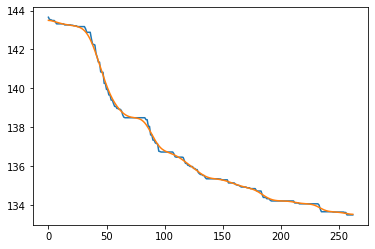

In [126]:
plt.plot(df.rtp)
plt.plot(df.rtp_smooth) # Gaussian filter

**Streamflow gradient:**

In [127]:
diff = abs(np.diff(df.rtp_smooth))

In [128]:
# Prepend a rtp difference value based on the mean of the first ten reaches
diff = np.insert(diff, 0, diff[:11].mean(), axis=0)

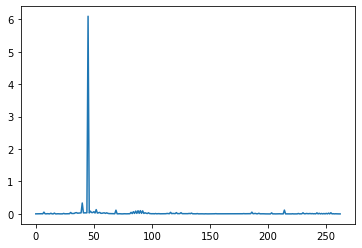

In [129]:
initial_gradient = diff / df.lengths # Initial parameter values for streamflow gradient
# The huge spike just before reach 50 should be filtered out
plt.plot(initial_gradient)

In [130]:
for i,j in enumerate(initial_gradient):
    if j > 1:
        initial_gradient[i] = 0.2

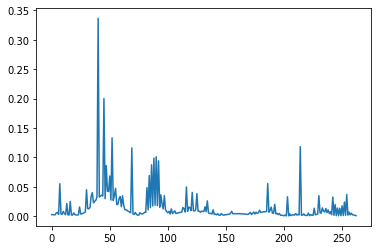

In [131]:
plt.plot(initial_gradient)

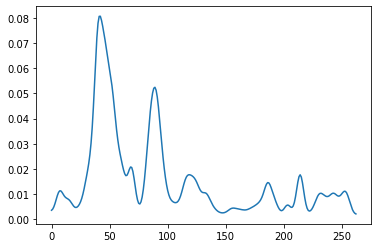

In [132]:
# Smoothen the gradient
initial_gradient = gaussian_filter1d(initial_gradient, 3)
plt.plot(initial_gradient) # These are the values that will be used as initial parameter values for the streamflow gradient

In [133]:
df['rgrd'] = initial_gradient

**Streambed thickness (rbth):**

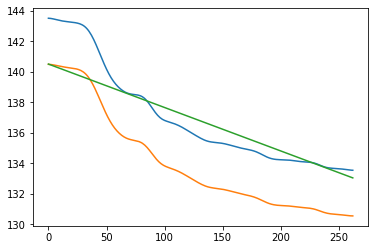

In [134]:
plt.plot(df.rtp_smooth)
plt.plot(gaussian_filter1d(df.rtp_smooth - 3, 3))

plt.plot(np.linspace(df.rtp_smooth.max() - 3, df.rtp_smooth.min() - 0.5, len(df.rtp_smooth)))

In [135]:
z = np.polyfit([i for i in range(len(df.rtp_smooth))], df.rtp_smooth, 3)
f = np.poly1d(z)

In [136]:
f

poly1d([-4.09037108e-07,  3.61078088e-04, -1.09203292e-01,  1.44873257e+02])

In [137]:
f[1] = -0.101

In [138]:
# calculate new x's and y's
x_new = np.linspace(0, len(df), len(df))
y_new = f(x_new)

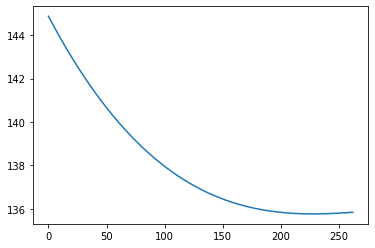

In [139]:
plt.plot(y_new)

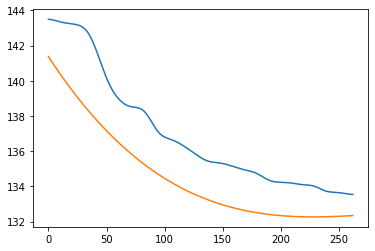

In [140]:
plt.plot(df.rtp_smooth)

plt.plot(y_new - 3.5)

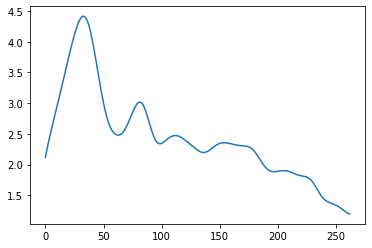

In [141]:
initial_depth = df.rtp_smooth - (y_new - 3.5)
plt.plot(initial_depth)

In [142]:
df['init_depth'] = initial_depth

#### Save preferred depth and streamflow gradient to csv
So that it can be used as preferred value parameters during the parameterization step (notebook 3)

In [143]:
# Save to file so that it can be imported as preferred value parameters during the parameterization step (NB3)
# If the number of pps would change (currently 53), this would have to be manually redone!
pd.DataFrame(
    {'init_rbtm':initial_depth[::5], 'init_rgrd': initial_gradient[::5]}
).to_csv(os.path.join(ml_ws, 'sfr_init_rbtm_rgrd.csv'))

### 3.3.XXX Temporary block for testing a smoother model surface at the streamflow location

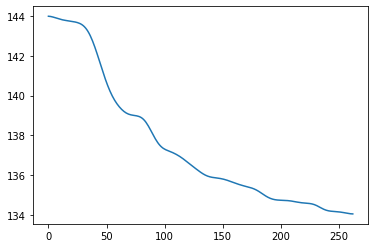

In [144]:
### Delete if it doesn't improve results
temp_top = gwf.disv.top.array
indices = [int(i) for i in df.cellids.values]
temp_top[indices] = df.rtp_smooth + .5
gwf.disv.top = temp_top
plt.plot(temp_top[indices])
### Delete if it doesn't improve results

### 3.3.4. Create the `PACKAGEDATA` input

We will now create a dictionary that hold the `PACKAGEDATA` input required by SFR. Starting by preprocessing `ncon`:

In [145]:
ncon = [2 for i in range(len(df))] # All reaches (except for the first and last) will have 2 connections; upstream and downstream.
ncon[0] = 1 # First reach will only have one connection
ncon[-1] = 1 # Last reach will only have one connection

Then we move on to the rest of parameters and display the dictionary as a dataframe:

In [146]:
sfr_packagedata = {
    'rno': df.index, # Reach numbers are in sequential order along creek flow path. Cannot be int64.
    'cellid': [(0, i) for i in df.cellids.values], # CellID is a tuple which contain layer number (zero indexed) and cell2d id.
    'rlen': [round(i, 2) for i in df.lengths.values], # Acquired from intersecting model grid with shapefile.
    'rwid': [2. for i in range(len(df))], # Creek Örbäcken is approximately 2 meters wide.
    'rgrd': [round(i, 4) for i in df.rgrd], # Sensible default value.
    'rtp': [round(i, 2) for i in df.rtp.values], # Sampled from DEM and then processed through smoothing algorithm.
    'rbth': [round(i, 2) for i in df.init_depth.values], # Bottom depth is unknown. This is a "best guess"-value.
    'rhk': [86.4 for i in range(len(df))], # Initial Hydraulic Conductivity guess. PEST will adjust this parameter.
    'man': [3e-02 for i in range(len(df))], # Manning's roughness coefficient. Sensible default value.
    'ncon': ncon, # All reaches (except for the first and last) will have 2 connections; upstream and downstream.
    'ustrf': [1 for i in range(len(df))], # Since there are no diversions this value will be 1 for all reaches
    'ndv': [0 for i in range(len(df))], # Since there are no diversions this value will be 0 for all reaches
}
sfr_packagedata_df = pd.DataFrame(sfr_packagedata)
display(sfr_packagedata_df)

rno     cellid  rlen  rwid    rgrd     rtp  rbth   rhk   man  ncon  \
0      0  (0, 2645)  5.88   2.0  0.0036  143.66  2.12  86.4  0.03     1   
1      1  (0, 2643)  1.85   2.0  0.0041  143.53  2.22  86.4  0.03     2   
2      2  (0, 2641)  3.56   2.0  0.0050  143.53  2.31  86.4  0.03     2   
3      3  (0, 2640)  5.53   2.0  0.0063  143.49  2.40  86.4  0.03     2   
4      4  (0, 2637)  2.84   2.0  0.0079  143.49  2.48  86.4  0.03     2   
..   ...        ...   ...   ...     ...     ...   ...   ...   ...   ...   
258  258    (0, 32)  2.07   2.0  0.0051  133.51  1.24  86.4  0.03     2   
259  259    (0, 30)  4.10   2.0  0.0039  133.51  1.22  86.4  0.03     2   
260  260    (0, 27)  3.67   2.0  0.0030  133.51  1.21  86.4  0.03     2   
261  261     (0, 5)  3.41   2.0  0.0024  133.51  1.20  86.4  0.03     2   
262  262     (0, 4)  3.67   2.0  0.0022  133.51  1.20  86.4  0.03     1   

     ustrf  ndv  
0        1    0  
1        1    0  
2        1    0  
3        1    0  
4        1    0  
..     ...  ...  
258      1    0  
259      1    0  
260      1    0  
261      1    0  
262      1    0  

[263 rows x 12 columns]

Add boundnames:

In [147]:
sfr_packagedata_df['bname'] = 'bound1'

In [148]:
sfr_bounds = {
    'bound1': [i for i in range(16)],
    'bound2': [i for i in range(16, 32)],
    'bound3': [i for i in range(32, 52)],
    'bound4': [i for i in range(52, 70)],
    'bound5': [i for i in range(70, 102)],
    'bound6': [i for i in range(102, 118)],
    'bound7': [i for i in range(118, 127)],
    'bound8': [i for i in range(127, 140)],
    'bound9': [i for i in range(140, 168)],
    'bound10': [i for i in range(168, 189)],
    'bound11': [i for i in range(189, 200)],
    'bound12': [i for i in range(200, 220)],
    'bound13': [i for i in range(220, 235)],
    'bound14': [i for i in range(235, 263)]
}

In [149]:
for k,v in sfr_bounds.items():
    for i in v:
        sfr_packagedata_df.loc[sfr_packagedata_df.rno == i, 'bname'] = k

In [150]:
sfr_packagedata_df

rno     cellid  rlen  rwid    rgrd     rtp  rbth   rhk   man  ncon  \
0      0  (0, 2645)  5.88   2.0  0.0036  143.66  2.12  86.4  0.03     1   
1      1  (0, 2643)  1.85   2.0  0.0041  143.53  2.22  86.4  0.03     2   
2      2  (0, 2641)  3.56   2.0  0.0050  143.53  2.31  86.4  0.03     2   
3      3  (0, 2640)  5.53   2.0  0.0063  143.49  2.40  86.4  0.03     2   
4      4  (0, 2637)  2.84   2.0  0.0079  143.49  2.48  86.4  0.03     2   
..   ...        ...   ...   ...     ...     ...   ...   ...   ...   ...   
258  258    (0, 32)  2.07   2.0  0.0051  133.51  1.24  86.4  0.03     2   
259  259    (0, 30)  4.10   2.0  0.0039  133.51  1.22  86.4  0.03     2   
260  260    (0, 27)  3.67   2.0  0.0030  133.51  1.21  86.4  0.03     2   
261  261     (0, 5)  3.41   2.0  0.0024  133.51  1.20  86.4  0.03     2   
262  262     (0, 4)  3.67   2.0  0.0022  133.51  1.20  86.4  0.03     1   

     ustrf  ndv    bname  
0        1    0   bound1  
1        1    0   bound1  
2        1    0   bound1  
3        1    0   bound1  
4        1    0   bound1  
..     ...  ...      ...  
258      1    0  bound14  
259      1    0  bound14  
260      1    0  bound14  
261      1    0  bound14  
262      1    0  bound14  

[263 rows x 13 columns]

Convert SFR package-data into MODFLOW/Flopy compatible input format:

In [151]:
sfr_pkgdata = [list(data) for data in sfr_packagedata_df.to_numpy()]

### 3.3.5 Create the `CONNECTIONDATA` input:

This is a fairly simple matter since there are no diversions along this section in creek Örbäcken (we treat the stream as a single unit).

In [152]:
# connectiondata IC (downstream negative, upstream positive)
sfr_conn_arr = np.dstack((sfr_packagedata['rno'], sfr_packagedata['rno'] - 1, (sfr_packagedata['rno'] + 1) * -1))[0]

In [153]:
# turn sfr_conn_arr into a list
sfr_conndata = [list(i) for i in sfr_conn_arr]

In [154]:
# remove upstream connection from first reach & downstream connection from last reach and display the data
sfr_conndata[0], sfr_conndata[-1] = sfr_conndata[0][:-1], sfr_conndata[-1][:-1]
sfr_conndata

[[0, -1],
 [1, 0, -2],
 [2, 1, -3],
 [3, 2, -4],
 [4, 3, -5],
 [5, 4, -6],
 [6, 5, -7],
 [7, 6, -8],
 [8, 7, -9],
 [9, 8, -10],
 [10, 9, -11],
 [11, 10, -12],
 [12, 11, -13],
 [13, 12, -14],
 [14, 13, -15],
 [15, 14, -16],
 [16, 15, -17],
 [17, 16, -18],
 [18, 17, -19],
 [19, 18, -20],
 [20, 19, -21],
 [21, 20, -22],
 [22, 21, -23],
 [23, 22, -24],
 [24, 23, -25],
 [25, 24, -26],
 [26, 25, -27],
 [27, 26, -28],
 [28, 27, -29],
 [29, 28, -30],
 [30, 29, -31],
 [31, 30, -32],
 [32, 31, -33],
 [33, 32, -34],
 [34, 33, -35],
 [35, 34, -36],
 [36, 35, -37],
 [37, 36, -38],
 [38, 37, -39],
 [39, 38, -40],
 [40, 39, -41],
 [41, 40, -42],
 [42, 41, -43],
 [43, 42, -44],
 [44, 43, -45],
 [45, 44, -46],
 [46, 45, -47],
 [47, 46, -48],
 [48, 47, -49],
 [49, 48, -50],
 [50, 49, -51],
 [51, 50, -52],
 [52, 51, -53],
 [53, 52, -54],
 [54, 53, -55],
 [55, 54, -56],
 [56, 55, -57],
 [57, 56, -58],
 [58, 57, -59],
 [59, 58, -60],
 [60, 59, -61],
 [61, 60, -62],
 [62, 61, -63],
 [63, 62, -64],
 [64, 63,

### 3.3.6 Create the `PERIODDATA` input:

In [155]:
sfr_spd = [[0, 'inflow', 18547]] # mean of gage2 for measured period

In [156]:
for i in sfr_packagedata['rno']:
    sfr_spd.append([i, 'rainfall', 0.1])

In [157]:
for i in sfr_packagedata['rno']:
    sfr_spd.append([i, 'evaporation', 0.001])

In [158]:
sfr_spd

[[0, 'inflow', 18547],
 [0, 'rainfall', 0.1],
 [1, 'rainfall', 0.1],
 [2, 'rainfall', 0.1],
 [3, 'rainfall', 0.1],
 [4, 'rainfall', 0.1],
 [5, 'rainfall', 0.1],
 [6, 'rainfall', 0.1],
 [7, 'rainfall', 0.1],
 [8, 'rainfall', 0.1],
 [9, 'rainfall', 0.1],
 [10, 'rainfall', 0.1],
 [11, 'rainfall', 0.1],
 [12, 'rainfall', 0.1],
 [13, 'rainfall', 0.1],
 [14, 'rainfall', 0.1],
 [15, 'rainfall', 0.1],
 [16, 'rainfall', 0.1],
 [17, 'rainfall', 0.1],
 [18, 'rainfall', 0.1],
 [19, 'rainfall', 0.1],
 [20, 'rainfall', 0.1],
 [21, 'rainfall', 0.1],
 [22, 'rainfall', 0.1],
 [23, 'rainfall', 0.1],
 [24, 'rainfall', 0.1],
 [25, 'rainfall', 0.1],
 [26, 'rainfall', 0.1],
 [27, 'rainfall', 0.1],
 [28, 'rainfall', 0.1],
 [29, 'rainfall', 0.1],
 [30, 'rainfall', 0.1],
 [31, 'rainfall', 0.1],
 [32, 'rainfall', 0.1],
 [33, 'rainfall', 0.1],
 [34, 'rainfall', 0.1],
 [35, 'rainfall', 0.1],
 [36, 'rainfall', 0.1],
 [37, 'rainfall', 0.1],
 [38, 'rainfall', 0.1],
 [39, 'rainfall', 0.1],
 [40, 'rainfall', 0.1],
 [4

### 3.3.7 Create the SFR model input

In [159]:
sfr = flopy.mf6.ModflowGwfsfr(
    gwf,
    nreaches=len(df),
    packagedata=sfr_pkgdata,
    connectiondata=sfr_conndata,
    maximum_iterations=100,
    unit_conversion=86400.,
    pname='sfr',
    perioddata=sfr_spd,
    print_input=True,
    print_flows=True,
    print_stage=True,
    save_flows=True,
    boundnames=True, # to be implemented after some history matching is done
    budget_filerecord=ml_name + ".sfr.bud",
)

##  Run model

In [160]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model hagfors_1...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package oc...
    writing package sto...
    writing package ghb...
INFORMATION: maxbound in ('gwf6', 'ghb', 'dimensions') changed to 242 based on size of stress_period_data
    writing package rch...
INFORMATION: maxbound in ('gwf6', 'rch', 'dimensions') changed to 2798 based on size of stress_period_data
    writing package sfr...


In [161]:
sim.run_simulation()

Exception: The program ..\bins\win\mf6 does not exist or is not executable.

## Review results and change initial heads to computed output for faster convergence

In [154]:
#Check the budget
mf_list = flopy.utils.Mf6ListBudget(os.path.join(ml_ws, f"{gwf.name}.lst"), timeunit='days') #MF6ListBudget is different from MfListBudget...*sigh*
incremental, cumulative = mf_list.get_budget()
incrementaldf, cumulativedf = mf_list.get_dataframes(start_datetime="01-09-2017")

incrementaldf

STO-SS_IN  STO-SY_IN       GHB_IN      RCH_IN       SFR_IN  \
2017-01-10  0.000000e+00        0.0  8613.797852  123.233704  7855.857422   
2021-02-09  1.105900e-15        0.0  8613.748047  123.233704  7855.830566   

                TOTAL_IN    STO-SS_OUT    STO-SY_OUT      GHB_OUT  RCH_OUT  \
2017-01-10  16592.888672  0.000000e+00  0.000000e+00  4958.945312      0.0   
2021-02-09  16592.812500  8.093800e-15  8.463600e-11  4959.063477      0.0   

                 SFR_OUT   TOTAL_OUT        IN-OUT  PERCENT_DISCREPANCY  
2017-01-10  11633.367188  16592.3125  5.759000e-01                  0.0  
2021-02-09  11633.749023  16592.8125  1.422000e-07                  0.0

Model solved with a run time of less than 10 seconds (considerably faster than the model built using ModelMuse). Lets visualize the results using a cross section:

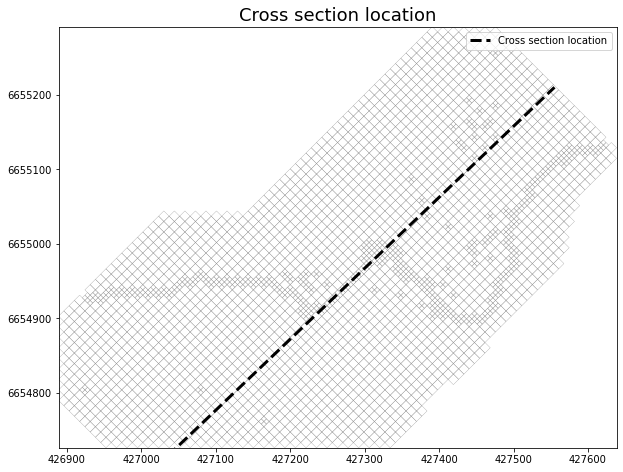

In [155]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
ax.set_title('Cross section location', fontsize=18)

# use PlotMapView to plot a DISV (vertex) model
mapview = flopy.plot.PlotMapView(gwf, layer=0)
linecollection = mapview.plot_grid(lw=0.25)

xsection = np.array([(427020, 6654700), (427555, 6655210)])
plt.plot(xsection.T[0], xsection.T[1], color='k', linestyle='--', lw=3, label='Cross section location')
    
plt.legend()
plt.show()

Read model solution:

In [156]:
headfile = '{}.hds'.format(ml_name)
fname = os.path.join(ml_ws, headfile)
hds = flopy.utils.binaryfile.HeadFile(fname)
h = hds.get_data()

Plot cross section:

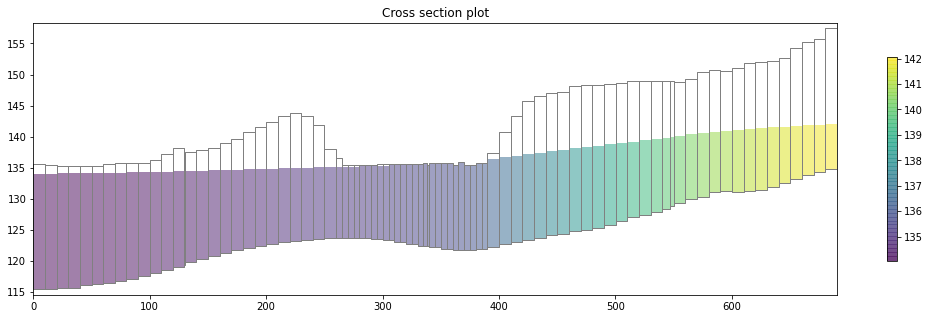

In [157]:
fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Cross section plot")

xsect = flopy.plot.PlotCrossSection(model=gwf, line={"line": xsection})
patch_collection = xsect.plot_array(h, head=h, alpha=0.5)
line_collection = xsect.plot_grid()
cb = plt.colorbar(patch_collection, shrink=0.75)

Some of the cells in layer 1 are dry. Considering the model is parametrically homogenous this is probably not a big issue at this point. Lets visualize the results for all layers using PlotMapView:

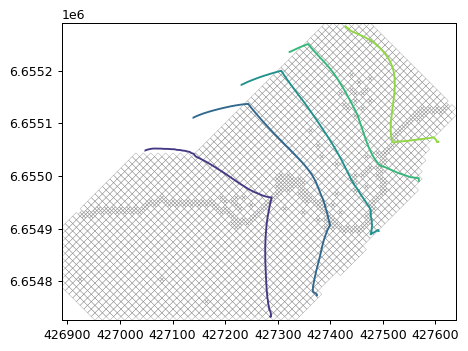

In [158]:
fig = plt.figure(figsize=(8,4), dpi=90)

modelmap = flopy.plot.PlotMapView(model=gwf)
linecollection = modelmap.plot_grid(lw=0.25)
contours = modelmap.contour_array(h)
    
plt.tight_layout()
plt.show()

Change initial conditions to computed output for faster convergence:

In [159]:
ic.strt = h

Set all data external:

In [160]:
sim.set_all_data_external(True) # OBS and TS should be initiated after this block

In [161]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model hagfors_1...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package oc...
    writing package sto...
    writing package ghb...
    writing package rch...
    writing package sfr...


# OBS and TS should be initiated after this block

### Add timeseries input for SFR perioddata
Start by removing the old package:

In [162]:
gwf.remove_package('sfr')

In [163]:
for file in os.listdir(ml_ws):
    if '.sfr' in file:
        os.remove(os.path.join(ml_ws, file))

Create a TS-file compatible perioddata block:

In [164]:
sfr_spd = [[0, 'inflow', 'inflow_reach1']]
for i in sfr_packagedata['rno']:
    sfr_spd.append([i, 'rainfall', 'rainf'])
for i in sfr_packagedata['rno']:
    sfr_spd.append([i, 'evaporation', 'evapo'])

add the new package

In [165]:
sfr = flopy.mf6.ModflowGwfsfr(
    gwf,
    nreaches=len(df),
    packagedata=sfr_pkgdata,
    connectiondata=sfr_conndata,
    maximum_iterations=100,
    unit_conversion=86400.,
    pname='sfr',
    perioddata=sfr_spd,
    print_input=True,
    print_flows=True,
    print_stage=True,
    save_flows=True,
    boundnames=True, # to be implemented after some history matching is done
    budget_filerecord=ml_name + ".sfr.bud",
)

Dynamically construct timeseriesinput. `time_inflow` is the inflow into reach 1 at each timesteps. This parameter will be adjusted by PEST during history matching:

In [166]:
n_outputs = []

for nper in range(tdis.nper.data):
    n_outputs.append(tdis.perioddata.array[nper][1])

In [167]:
timesteps = np.linspace(0, 1491, sum(n_outputs))
timesteps = timesteps + 1
timesteps = np.insert(timesteps, 0, 0)

In [168]:
#timesteps = np.linspace(0, 1491, sum(n_outputs))
time_inflow = [18547 for i in range(len(timesteps))] # Reach 1 inflow (mean of GAGE2 for the measured period)
time_rainfall = [0.05 for i in range(len(timesteps))] # Rainfall ontop of reaches
time_evaporation = [0.001 for i in range(len(timesteps))] # Rainfall ontop of reaches

Create TS-data for reach 1 inflow:

In [169]:
ts_data_infr1 = [(time, flow) for time, flow in zip(timesteps, time_inflow)]

In [170]:
ts_data_rainf = [(time, rainfall) for time, rainfall in zip(timesteps, time_rainfall)]

In [171]:
ts_data_evapo = [(time, evaporation) for time, evaporation in zip(timesteps, time_evaporation)]

Initialize the TS-package:

In [172]:
# initialize time series
sfr.ts.initialize(
    filename='sfr_reach1_inflow.ts',
    timeseries=ts_data_infr1,
    time_series_namerecord='inflow_reach1',
    interpolation_methodrecord='linearend', # should this be linear or linearend?
)

In [173]:
# initialize time series
sfr.ts.append_package(
    filename='sfr_reach_rainfall.ts',
    timeseries=ts_data_rainf,
    time_series_namerecord='rainf',
    interpolation_methodrecord='linearend', # should this be linear or linearend?
)

In [174]:
# initialize time series
sfr.ts.append_package(
    filename='sfr_reach_evaporation.ts',
    timeseries=ts_data_evapo,
    time_series_namerecord='evapo',
    interpolation_methodrecord='linearend', # should this be linear or linearend?
)

## Setup Observations

In [175]:
observations_pth = os.path.join('..', 'data', 'observations') # Measured data (field obs)

### SFR observations

In [176]:
sfrobs = pd.read_excel(os.path.join(observations_pth, 'obs_flow_and_stage.xlsx'))
sfrobs['shapely_point'] = [Point(row['POINT_X'], row['POINT_Y']) for index, row in sfrobs.iterrows()]
sfrobs['cell2d'] = [ix.intersect(i).cellids[0] for i in sfrobs['shapely_point']]
sfrobs['NAME'] = sfrobs['NAME'].str.lower()
display(sfrobs)

NAME        POINT_X       POINT_Y    TYPE  \
0    ni15-o1-stg  427391.988166  6.654917e+06   STAGE   
1   ni15-o44-stg  427385.272148  6.654938e+06   STAGE   
2   ni15-o46-stg  427316.293421  6.655000e+06   STAGE   
3   ni15-o47-stg  427294.946661  6.654962e+06   STAGE   
4   ni15-o48-stg  427166.670722  6.654947e+06   STAGE   
5         gage-1  427070.614000  6.654949e+06  INFLOW   
6         gage-2  427030.760000  6.654934e+06  INFLOW   
7   dts_inflow_1  427418.522000  6.654902e+06     SFR   
8   dts_inflow_2  427392.456000  6.654919e+06     SFR   
9   dts_inflow_3  427385.666000  6.654938e+06     SFR   
10  dts_inflow_4  427316.217000  6.655000e+06     SFR   

                          shapely_point  cell2d  
0   POINT (427391.988166 6654917.31795)    2506  
1   POINT (427385.272148 6654938.18864)    2295  
2   POINT (427316.293421 6655000.15848)    1590  
3   POINT (427294.946661 6654962.31574)    1682  
4    POINT (427166.670722 6654946.6169)     947  
5        POINT (427070.614 6654948.935)     377  
6          POINT (427030.76 6654934.26)     246  
7        POINT (427418.522 6654902.216)    2736  
8        POINT (427392.456 6654918.628)    2504  
9        POINT (427385.666 6654937.715)    2295  
10       POINT (427316.217 6655000.206)    1590

In [177]:
sfr_packagedata_df['cell2d'] = [i[1] for i in sfr_packagedata_df.cellid.values]
merged_sfr_obs = pd.merge(sfrobs, sfr_packagedata_df, on=['cell2d'], how='inner')
merged_sfr_obs

NAME        POINT_X       POINT_Y    TYPE  \
0  ni15-o44-stg  427385.272148  6.654938e+06   STAGE   
1  dts_inflow_3  427385.666000  6.654938e+06     SFR   
2  ni15-o46-stg  427316.293421  6.655000e+06   STAGE   
3  dts_inflow_4  427316.217000  6.655000e+06     SFR   
4  ni15-o47-stg  427294.946661  6.654962e+06   STAGE   
5  ni15-o48-stg  427166.670722  6.654947e+06   STAGE   
6        gage-1  427070.614000  6.654949e+06  INFLOW   
7        gage-2  427030.760000  6.654934e+06  INFLOW   
8  dts_inflow_1  427418.522000  6.654902e+06     SFR   
9  dts_inflow_2  427392.456000  6.654919e+06     SFR   

                         shapely_point  cell2d  rno     cellid  rlen  rwid  \
0  POINT (427385.272148 6654938.18864)    2295  107  (0, 2295)  5.88   2.0   
1       POINT (427385.666 6654937.715)    2295  107  (0, 2295)  5.88   2.0   
2  POINT (427316.293421 6655000.15848)    1590  141  (0, 1590)  3.31   2.0   
3       POINT (427316.217 6655000.206)    1590  141  (0, 1590)  3.31   2.0   
4  POINT (427294.946661 6654962.31574)    1682  156  (0, 1682)  5.13   2.0   
5   POINT (427166.670722 6654946.6169)     947  193   (0, 947)  4.71   2.0   
6       POINT (427070.614 6654948.935)     377  220   (0, 377)  5.32   2.0   
7         POINT (427030.76 6654934.26)     246  232   (0, 246)  5.67   2.0   
8       POINT (427418.522 6654902.216)    2736   93  (0, 2736)  6.36   2.0   
9       POINT (427392.456 6654918.628)    2504  102  (0, 2504)  7.31   2.0   

     rgrd     rtp  rbth   rhk   man  ncon  ustrf  ndv    bname  
0  0.0066  136.74  2.44  86.4  0.03     2      1    0   bound6  
1  0.0066  136.74  2.44  86.4  0.03     2      1    0   bound6  
2  0.0042  135.36  2.23  86.4  0.03     2      1    0   bound9  
3  0.0042  135.36  2.23  86.4  0.03     2      1    0   bound9  
4  0.0045  135.15  2.35  86.4  0.03     2      1    0   bound9  
5  0.0072  134.23  1.90  86.4  0.03     2      1    0  bound11  
6  0.0044  134.08  1.82  86.4  0.03     2      1    0  bound13  
7  0.0103  134.08  1.66  86.4  0.03     2      1    0  bound13  
8  0.0397  137.17  2.47  86.4  0.03     2      1    0   bound5  
9  0.0085  136.74  2.37  86.4  0.03     2      1    0   bound6

NI15-O1-STG is lost (sits in the cell next to the intersected cell)

In [178]:
sfr_packagedata_df.loc[sfr_packagedata_df['cell2d'] > 2500]

rno     cellid  rlen  rwid    rgrd     rtp  rbth   rhk   man  ncon  \
0      0  (0, 2645)  5.88   2.0  0.0036  143.66  2.12  86.4  0.03     1   
1      1  (0, 2643)  1.85   2.0  0.0041  143.53  2.22  86.4  0.03     2   
2      2  (0, 2641)  3.56   2.0  0.0050  143.53  2.31  86.4  0.03     2   
3      3  (0, 2640)  5.53   2.0  0.0063  143.49  2.40  86.4  0.03     2   
4      4  (0, 2637)  2.84   2.0  0.0079  143.49  2.48  86.4  0.03     2   
..   ...        ...   ...   ...     ...     ...   ...   ...   ...   ...   
99    99  (0, 2588)  5.69   2.0  0.0137  136.74  2.34  86.4  0.03     2   
100  100  (0, 2505)  6.10   2.0  0.0114  136.74  2.34  86.4  0.03     2   
101  101  (0, 2503)  3.66   2.0  0.0097  136.74  2.36  86.4  0.03     2   
102  102  (0, 2504)  7.31   2.0  0.0085  136.74  2.37  86.4  0.03     2   
103  103  (0, 2507)  1.95   2.0  0.0077  136.74  2.39  86.4  0.03     2   

     ustrf  ndv   bname  cell2d  
0        1    0  bound1    2645  
1        1    0  bound1    2643  
2        1    0  bound1    2641  
3        1    0  bound1    2640  
4        1    0  bound1    2637  
..     ...  ...     ...     ...  
99       1    0  bound5    2588  
100      1    0  bound5    2505  
101      1    0  bound5    2503  
102      1    0  bound6    2504  
103      1    0  bound6    2507  

[69 rows x 14 columns]

Change cell2d 2527 to 2526:

In [179]:
sfrobs.loc[sfrobs['NAME'] == 'ni15-o1-stg', 'cell2d'] = 2507
merged_sfr_obs = pd.merge(sfrobs, sfr_packagedata_df, on=['cell2d'], how='inner')
merged_sfr_obs

NAME        POINT_X       POINT_Y    TYPE  \
0    ni15-o1-stg  427391.988166  6.654917e+06   STAGE   
1   ni15-o44-stg  427385.272148  6.654938e+06   STAGE   
2   dts_inflow_3  427385.666000  6.654938e+06     SFR   
3   ni15-o46-stg  427316.293421  6.655000e+06   STAGE   
4   dts_inflow_4  427316.217000  6.655000e+06     SFR   
5   ni15-o47-stg  427294.946661  6.654962e+06   STAGE   
6   ni15-o48-stg  427166.670722  6.654947e+06   STAGE   
7         gage-1  427070.614000  6.654949e+06  INFLOW   
8         gage-2  427030.760000  6.654934e+06  INFLOW   
9   dts_inflow_1  427418.522000  6.654902e+06     SFR   
10  dts_inflow_2  427392.456000  6.654919e+06     SFR   

                          shapely_point  cell2d  rno     cellid  rlen  rwid  \
0   POINT (427391.988166 6654917.31795)    2507  103  (0, 2507)  1.95   2.0   
1   POINT (427385.272148 6654938.18864)    2295  107  (0, 2295)  5.88   2.0   
2        POINT (427385.666 6654937.715)    2295  107  (0, 2295)  5.88   2.0   
3   POINT (427316.293421 6655000.15848)    1590  141  (0, 1590)  3.31   2.0   
4        POINT (427316.217 6655000.206)    1590  141  (0, 1590)  3.31   2.0   
5   POINT (427294.946661 6654962.31574)    1682  156  (0, 1682)  5.13   2.0   
6    POINT (427166.670722 6654946.6169)     947  193   (0, 947)  4.71   2.0   
7        POINT (427070.614 6654948.935)     377  220   (0, 377)  5.32   2.0   
8          POINT (427030.76 6654934.26)     246  232   (0, 246)  5.67   2.0   
9        POINT (427418.522 6654902.216)    2736   93  (0, 2736)  6.36   2.0   
10       POINT (427392.456 6654918.628)    2504  102  (0, 2504)  7.31   2.0   

      rgrd     rtp  rbth   rhk   man  ncon  ustrf  ndv    bname  
0   0.0077  136.74  2.39  86.4  0.03     2      1    0   bound6  
1   0.0066  136.74  2.44  86.4  0.03     2      1    0   bound6  
2   0.0066  136.74  2.44  86.4  0.03     2      1    0   bound6  
3   0.0042  135.36  2.23  86.4  0.03     2      1    0   bound9  
4   0.0042  135.36  2.23  86.4  0.03     2      1    0   bound9  
5   0.0045  135.15  2.35  86.4  0.03     2      1    0   bound9  
6   0.0072  134.23  1.90  86.4  0.03     2      1    0  bound11  
7   0.0044  134.08  1.82  86.4  0.03     2      1    0  bound13  
8   0.0103  134.08  1.66  86.4  0.03     2      1    0  bound13  
9   0.0397  137.17  2.47  86.4  0.03     2      1    0   bound5  
10  0.0085  136.74  2.37  86.4  0.03     2      1    0   bound6

OK. Now it's there. Continuing...

In [180]:
stage_obs = merged_sfr_obs.loc[merged_sfr_obs['TYPE'] == 'STAGE']
gage_obs = merged_sfr_obs.loc[merged_sfr_obs['TYPE'] == 'INFLOW']
dts_obs = merged_sfr_obs.loc[merged_sfr_obs['TYPE'] == 'SFR']
sfrobs_obspkg_stage = [(row['NAME'], row['TYPE'], row['rno']) for index, row in stage_obs.iterrows()]
sfrobs_obspkg_gage = [(row['NAME'], row['TYPE'], row['rno']) for index, row in gage_obs.iterrows()]
sfrobs_obspkg_dts = [(row['NAME'], row['TYPE'], row['rno']) for index, row in dts_obs.iterrows()]
sfrobs_obspkg_stage
sfrobs_obspkg_gage
sfrobs_obspkg_dts

[('dts_inflow_3', 'SFR', 107),
 ('dts_inflow_4', 'SFR', 141),
 ('dts_inflow_1', 'SFR', 93),
 ('dts_inflow_2', 'SFR', 102)]

Setup gw/sw exchange flux and outflow **model predictions**:

In [181]:
#sfrobs_obspkg_leak = [(f'lk-{i+1}', 'SFR', i+1) for i in range(sfr.nreaches.data)]
#sfrobs_obspkg_outflow = [(f'of-{i+1}', 'OUTFLOW', i+1) for i in range(sfr.nreaches.data)]
#sfrobs_obspkg_leak[:5] # this will have to be changed once number of reaches are reduced

In [182]:
#sfrobs_obspkg_leak_tmp = [('lk-70', 'SFR', 70), ('lk-140', 'SFR', 140), ('lk-210', 'SFR', 210)]

In [183]:
# This observation is the main prediction
sfrobs_obspkg_pred_flux = [(f'flux-{k}', 'SFR', k) for k,v in sfr_bounds.items()]

In [184]:
# These observations are recorded for prediction & troubleshooting purposes
sfrobs_obspkg_pred_outflow = [(f'of-{k}', 'OUTFLOW', k) for k,v in sfr_bounds.items()]
sfrobs_obspkg_pred_inflow = [(f'if-{k}', 'INFLOW', k) for k,v in sfr_bounds.items()]

In [185]:
# These observations are recorded for troubleshooting purposes
sfrobs_obspkg_outflow_all = [(f'of-{i+1}', 'OUTFLOW', i+1) for i in range(sfr.nreaches.data)]
sfrobs_obspkg_outflow_all_historymatching = [(f'ofh-{i+1}', 'OUTFLOW', i+1) for i in range(sfr.nreaches.data)] # For history matching
sfrobs_obspkg_inflow_all = [(f'if-{i+1}', 'INFLOW', i+1) for i in range(sfr.nreaches.data)]
sfrobs_obspkg_leak_all = [(f'lk-{i+1}', 'SFR', i+1) for i in range(sfr.nreaches.data)]

In [186]:
# Split outflow into two parts (so as to be readable by OLPROC)
# This will be used as a "creative" way of history matching, i.e.
# Ensure that outflow is occuring in all reaches except the last
no_of_reaches = len(sfrobs_obspkg_outflow_all[:-1])
sfrobs_obspkg_outflow_hm_1pt = sfrobs_obspkg_outflow_all_historymatching[:-1][ : int(no_of_reaches / 2)]
sfrobs_obspkg_outflow_1pt = sfrobs_obspkg_outflow_all[:-1][ : int(no_of_reaches / 2)]
sfrobs_obspkg_outflow_2pt = sfrobs_obspkg_outflow_all[:-1][int(no_of_reaches / 2) : ]
sfrobs_obspkg_leak_1pt = sfrobs_obspkg_leak_all[ : int(no_of_reaches / 2)]
sfrobs_obspkg_leak_2pt = sfrobs_obspkg_leak_all[int(no_of_reaches / 2) : ]

Build obs data

In [187]:
# build obs data
sfr_obs = {
    'sfr_stage.obs.csv': sfrobs_obspkg_stage, # For history matching against stream stage
    'sfr_gage.obs.csv': sfrobs_obspkg_gage, # For history matching against stream flow
    'sfr_dts.obs.csv': sfrobs_obspkg_dts, # For history matching against distributed temperature sensor
    'sfr_pred_flux.obs.csv': sfrobs_obspkg_pred_flux, # Bound SW/GW exchange prediction
    'sfr_pred_outflow.obs.csv': sfrobs_obspkg_pred_outflow, # Bound stream-flow prediction (outflow, sum?)
    'sfr_outflow_hm_1pt.obs.csv': sfrobs_obspkg_outflow_hm_1pt, # Outflow for every reach, first half.
    'sfr_outflow_1pt.obs.csv': sfrobs_obspkg_outflow_1pt, # Outflow for every reach, first half.
    'sfr_outflow_2pt.obs.csv': sfrobs_obspkg_outflow_2pt, # Outflow for every reach, second half.
    'sfr_flux_1pt.obs.csv': sfrobs_obspkg_leak_1pt, # Leakage rates for every reach, first half.
    'sfr_flux_2pt.obs.csv': sfrobs_obspkg_leak_2pt, # Leakage rates for every reach, second half.
    'sfr_flux_all.obs.csv': sfrobs_obspkg_leak_all,
    'sfr_outflow_all.obs.csv': sfrobs_obspkg_outflow_all,
}

In [188]:
sfr.obs.initialize(
    filename = '{}.sfr.obs'.format(ml_name),
    digits = 10,
    print_input = True,
    continuous = sfr_obs
)

### Head observations

In [189]:
headobs['shapely_point'] = [Point(row['x'], row['y']) for index, row in headobs.iterrows()]

In [190]:
headobs['cell2d'] = [ix.intersect(i).cellids[0] for i in headobs['shapely_point']]

In [191]:
display(headobs)

name            x            y                          shapely_point  \
0      b10-1  427074.7094  6654805.174        POINT (427074.7094 6654805.174)   
1      b14-1  427474.4248  6655148.009        POINT (427474.4248 6655148.009)   
2      b15-1  427480.5444  6655184.865        POINT (427480.5444 6655184.865)   
3      b16-1  427409.5473  6655023.271  POINT (427409.5473 6655023.271000001)   
4       b2-1  427384.1720  6655037.189   POINT (427384.172 6655037.188999999)   
..       ...          ...          ...                                    ...   
58  ni1712-1  427416.8257  6654931.403        POINT (427416.8257 6654931.403)   
59  ni1801-1  427199.3878  6654953.654        POINT (427199.3878 6654953.654)   
60  ni1802-1  427206.0186  6654952.834        POINT (427206.0186 6654952.834)   
61  ni1803-1  427211.6349  6654950.927        POINT (427211.6349 6654950.927)   
62  ni1804-1  427218.5725  6654949.079        POINT (427218.5725 6654949.079)   

    cell2d  
0     1265  
1     1732  
2     1428  
3     2023  
4     1803  
..     ...  
58    2597  
59    1117  
60    1119  
61    1203  
62    1292  

[63 rows x 5 columns]

In [192]:
headobs_input = [(row['name'], 'HEAD', (0, row['cell2d']), (0, row['cell2d'] + 1)) for index, row in headobs.iterrows()]
headobs_input

[('b10-1', 'HEAD', (0, 1265), (0, 1266)),
 ('b14-1', 'HEAD', (0, 1732), (0, 1733)),
 ('b15-1', 'HEAD', (0, 1428), (0, 1429)),
 ('b16-1', 'HEAD', (0, 2023), (0, 2024)),
 ('b2-1', 'HEAD', (0, 1803), (0, 1804)),
 ('b22-1', 'HEAD', (0, 1515), (0, 1516)),
 ('b26', 'HEAD', (0, 1521), (0, 1522)),
 ('b29', 'HEAD', (0, 1603), (0, 1604)),
 ('b34', 'HEAD', (0, 2309), (0, 2310)),
 ('b35', 'HEAD', (0, 2314), (0, 2315)),
 ('b36', 'HEAD', (0, 2415), (0, 2416)),
 ('b37', 'HEAD', (0, 2421), (0, 2422)),
 ('b4', 'HEAD', (0, 994), (0, 995)),
 ('b8-2', 'HEAD', (0, 2056), (0, 2057)),
 ('b9-2', 'HEAD', (0, 348), (0, 349)),
 ('kb1-1', 'HEAD', (0, 2406), (0, 2407)),
 ('kb4-3', 'HEAD', (0, 1296), (0, 1297)),
 ('ni1403-2', 'HEAD', (0, 2424), (0, 2425)),
 ('ni1404-1', 'HEAD', (0, 1517), (0, 1518)),
 ('ni1405-1', 'HEAD', (0, 2243), (0, 2244)),
 ('ni1407-2', 'HEAD', (0, 1510), (0, 1511)),
 ('ni1408-1', 'HEAD', (0, 1415), (0, 1416)),
 ('ni1409-1', 'HEAD', (0, 1724), (0, 1725)),
 ('ni1410-1', 'HEAD', (0, 1729), (0, 1

In [193]:
# observations
obs_recarray = {'{}.obs.csv'.format('head'): headobs_input}
obs = flopy.mf6.ModflowUtlobs(
    gwf,
    pname = 'gwf_obs',
    filename = '{}.obs'.format(ml_name),
    digits = 10,
    print_input = True,
    continuous = obs_recarray
)

Rewrite simulation a final time to reflect refencing to SFR TS-file:

In [194]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model hagfors_1...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package oc...
    writing package sto...
    writing package ghb...
    writing package rch...
    writing package sfr...
    writing package ts_0...
    writing package ts_1...
    writing package ts_2...
    writing package obs_0...
    writing package gwf_obs...


In [195]:
sim.run_simulation()

FloPy is using the following executable to run the model: ..\bins\win\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                   VERSION 6.3.0 release candidate 01/22/2022
                               ***DEVELOP MODE***

   MODFLOW 6 compiled Jan 22 2022 02:25:10 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.5.0
                             Build 20211109_000000

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that neither the USGS nor t

    Solving:  Stress period:     2    Time step:   127
    Solving:  Stress period:     2    Time step:   128
    Solving:  Stress period:     2    Time step:   129
    Solving:  Stress period:     2    Time step:   130
    Solving:  Stress period:     2    Time step:   131
    Solving:  Stress period:     2    Time step:   132
    Solving:  Stress period:     2    Time step:   133
    Solving:  Stress period:     2    Time step:   134
    Solving:  Stress period:     2    Time step:   135
    Solving:  Stress period:     2    Time step:   136
    Solving:  Stress period:     2    Time step:   137
    Solving:  Stress period:     2    Time step:   138
    Solving:  Stress period:     2    Time step:   139
    Solving:  Stress period:     2    Time step:   140
    Solving:  Stress period:     2    Time step:   141
    Solving:  Stress period:     2    Time step:   142
    Solving:  Stress period:     2    Time step:   143
    Solving:  Stress period:     2    Time step:   144
    Solvin

(True, [])

In [196]:
#Check the budget
mf_list = flopy.utils.Mf6ListBudget(os.path.join(ml_ws, f"{gwf.name}.lst"), timeunit='days') #MF6ListBudget is different from MfListBudget...*sigh*
incremental, cumulative = mf_list.get_budget()
incrementaldf, cumulativedf = mf_list.get_dataframes(start_datetime="01-09-2017")

incrementaldf

STO-SS_IN     STO-SY_IN       GHB_IN      RCH_IN       SFR_IN  \
2017-01-10  0.000000e+00  0.000000e+00  8614.636719  123.233704  7855.817871   
2021-02-09  7.506100e-15  7.495500e-11  8614.640625  123.233704  7855.823242   

                TOTAL_IN    STO-SS_OUT  STO-SY_OUT      GHB_OUT  RCH_OUT  \
2017-01-10  16593.687500  0.000000e+00         0.0  4958.474121      0.0   
2021-02-09  16593.697266  1.190000e-15         0.0  4958.444824      0.0   

                 SFR_OUT     TOTAL_OUT        IN-OUT  PERCENT_DISCREPANCY  
2017-01-10  11635.273438  16593.748047 -5.969600e-02                 -0.0  
2021-02-09  11635.252930  16593.697266 -1.635100e-07                 -0.0

In [197]:
# get the specific discharge from the cell budget file
cbb_file = os.path.join(ml_ws, f'{ml_name}.cbb')
cbb = flopy.utils.CellBudgetFile(cbb_file)

# get the head from the head file
head_file = os.path.join(ml_ws, f'{ml_name}.hds')
head = flopy.utils.HeadFile(head_file)
hdata = head.get_alldata()

No handles with labels found to put in legend.


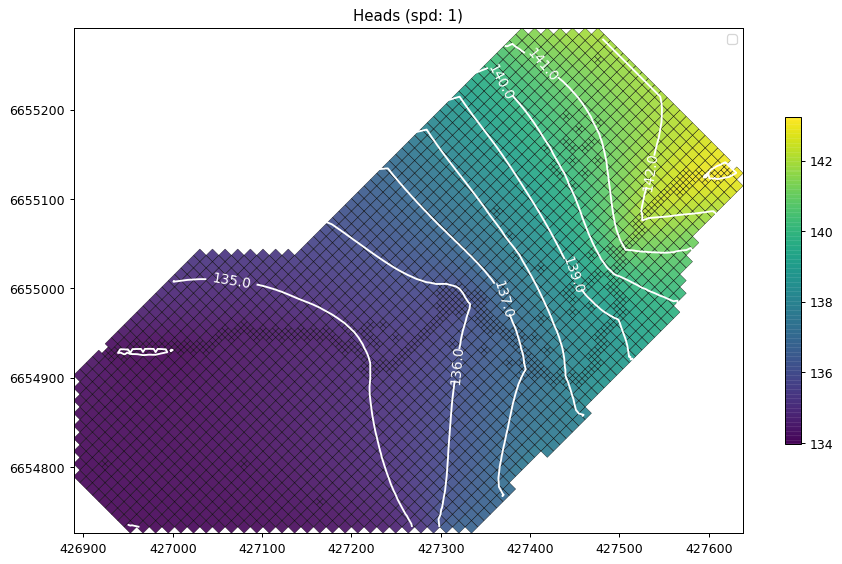

In [198]:
spd = 1

fig = plt.figure(figsize=(12, 12), dpi=90)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates

mapview = flopy.plot.PlotMapView(gwf, layer=0)
linecollection = mapview.plot_grid(lw=0.25, color='k')
quadmesh = mapview.plot_array(a=hdata[spd], alpha=0.9, masked_values=[1e30])
plt.colorbar(quadmesh, shrink=0.4);

levels = np.arange(130, 145, 1.0)
contour_set = mapview.contour_array(hdata[spd], levels=levels, colors='white')
plt.clabel(contour_set, fmt="%.1f", colors='white', fontsize=11)


plt.title(f'Heads (spd: {spd})')
plt.legend()
plt.show()

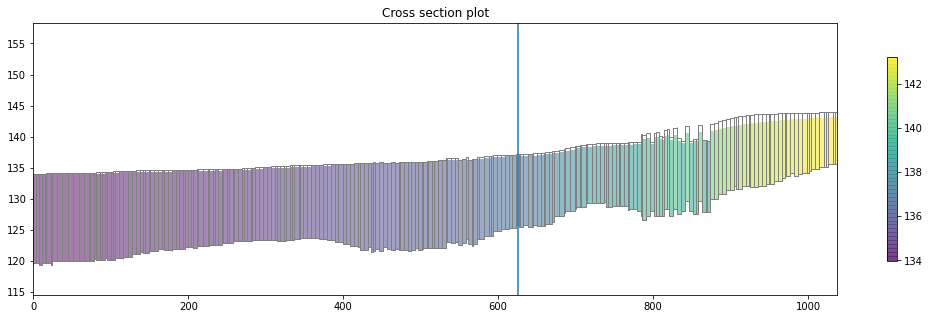

In [199]:
fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Cross section plot")
ax.axvline(x=427525.269-426900)
xsect = flopy.plot.PlotCrossSection(model=gwf, line={"line": orbacken_shp})
patch_collection = xsect.plot_array(h, head=h, alpha=0.5)
line_collection = xsect.plot_grid()
cb = plt.colorbar(patch_collection, shrink=0.75)

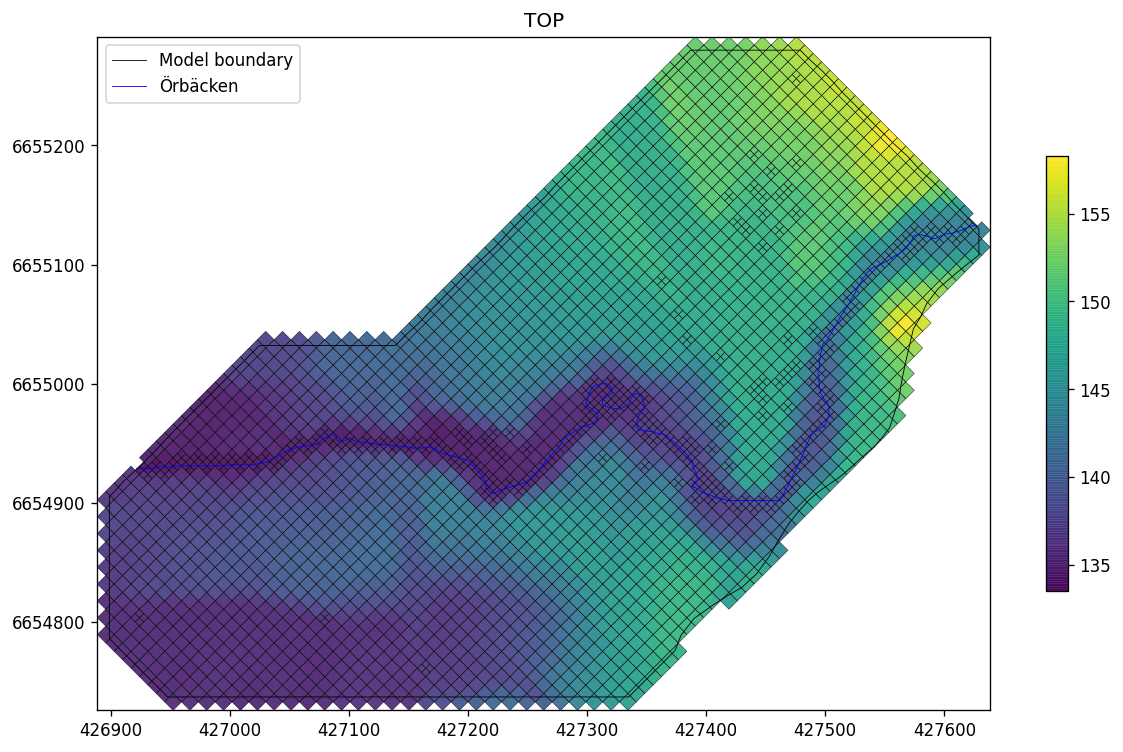

In [200]:
spd = 1

fig = plt.figure(figsize=(12, 12), dpi=120)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates

mapview = flopy.plot.PlotMapView(gwf, layer=0)
linecollection = mapview.plot_grid(lw=0.25, color='k')
quadmesh = mapview.plot_array(a=gwf.disv.top.data, alpha=0.9, masked_values=[1e30])
plt.colorbar(quadmesh, shrink=0.4);

ax.plot(mlb_shape[:,0],mlb_shape[:,1], c='k', lw=0.5, label='Model boundary')
ax.plot(orbacken_shp[:,0],orbacken_shp[:,1], c='blue', lw=0.5, label='Örbäcken')


plt.title(f'TOP')
plt.legend()
plt.show()

End of notebook.